In [1]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import json
import io
import copy
from functools import partial
from IPython.display import Image
from get_data import get_fred_data
import yfinance as yf
from datetime import date
from importlib import reload

import time

import simulation 
from utils import *

## Get some historical data to experiment with

In [2]:
cpi = get_fred_data('CPIAUCSL','Inflation')
cpi=cpi.pct_change()
cpi.index=cpi.index + pd.tseries.offsets.MonthEnd()

rfr = (0.01/12.0)*get_fred_data('DTB3','Cash').fillna(method='ffill')
rfr = rfr.resample('M').last()

bonds = get_fred_data('BAMLCC0A0CMTRIV','Bonds')
bonds = bonds.resample('M').last()
bonds = bonds.pct_change().fillna(0)

sptr = yf.download('^SP500TR')
sptr.index=sptr.index.tz_localize(None)
r_eq=sptr[['Adj Close']].resample('M').last()
r_eq=r_eq.pct_change().fillna(0).rename(columns={'Adj Close':'Stocks'})

r = pd.merge(r_eq,rfr,left_index=True,right_index=True,how='inner')
r = pd.merge(r,bonds,left_index=True,right_index=True,how='inner')
r = pd.merge(r,cpi,left_index=True,right_index=True,how='inner')
display(r.head())
display(r.tail())
display(r.corr())

[*********************100%***********************]  1 of 1 completed


Stocks      Cash     Bonds  Inflation
1988-01-31  0.000000  0.004700  0.038303   0.003460
1988-02-29  0.046646  0.004683  0.016803   0.001724
1988-03-31 -0.030911  0.004758 -0.011387   0.002582
1988-04-30  0.011066  0.004983 -0.009911   0.006009
1988-05-31  0.008635  0.005358 -0.007576   0.002560

Stocks      Cash     Bonds  Inflation
2022-10-31  0.080961  0.003383 -0.011146   0.004883
2022-11-30  0.055885  0.003558  0.049174   0.002050
2022-12-31 -0.057615  0.003583 -0.002117   0.001313
2023-01-31  0.062834  0.003817  0.038889   0.005171
2023-02-28 -0.024400  0.003933 -0.029129   0.003700

Stocks      Cash     Bonds  Inflation
Stocks     1.000000  0.029175  0.372781  -0.006655
Cash       0.029175  1.000000  0.089011   0.188820
Bonds      0.372781  0.089011  1.000000  -0.119343
Inflation -0.006655  0.188820 -0.119343   1.000000

In [3]:
r_ann=r.assign(year=r.index.year).groupby('year').sum()

In [4]:
r_ann.corr().style.background_gradient('Blues')

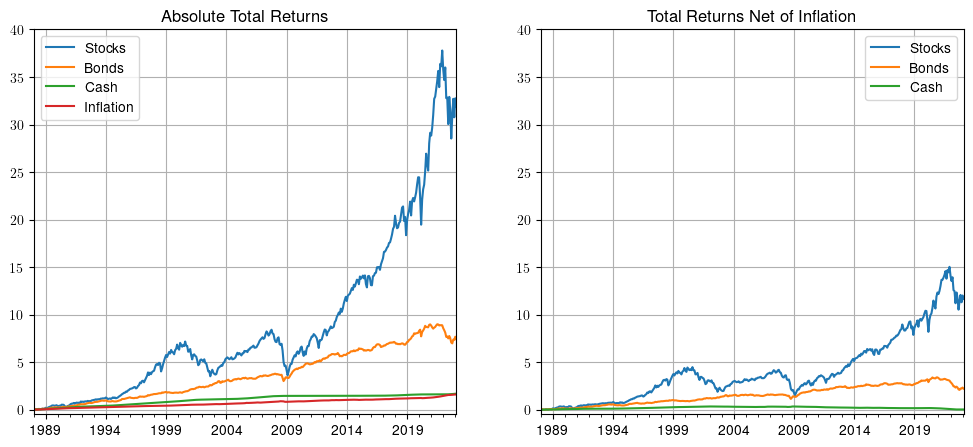

In [5]:
re=r['Stocks'].values
rb=r['Bonds'].values
rf=r['Cash'].values

rei=r['Stocks'].values-r['Inflation'].values
rbi=r['Bonds'].values-r['Inflation'].values
rfi=r['Cash'].values-r['Inflation'].values
returns_data=r[['Stocks','Bonds','Cash','Inflation']].values
returns_data_infl=np.column_stack((rei,rbi,rfi))
_,ax=plt.subplots(1,2,figsize=(12,5))
((1.0+r[['Stocks','Bonds','Cash','Inflation']]).cumprod(axis=0)-1).plot(ax=ax[0])
ax[0].grid()
ax[0].set_title('Absolute Total Returns')
ax[0].set_ylim(-0.5,40)
((1.0+pd.DataFrame(returns_data_infl,columns=['Stocks','Bonds','Cash'],index=r.index)).cumprod(axis=0)-1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_title('Total Returns Net of Inflation')
ax[1].set_ylim(-0.5,40)
plt.show()

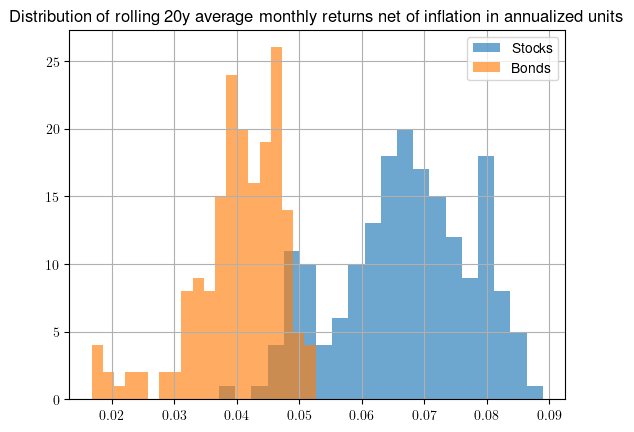

In [6]:
_,ax=plt.subplots()
(12.*(r['Stocks']-r['Inflation']).rolling(240).mean().dropna()).hist(bins=20,ax=ax,alpha=0.65,label='Stocks')
(12.*(r['Bonds']-r['Inflation']).rolling(240).mean().dropna()).hist(bins=20,ax=ax,alpha=0.65,label='Bonds')
ax.legend()
ax.set_title('Distribution of rolling 20y average monthly returns net of inflation in annualized units')
plt.show()

## Simulate future returns

In [7]:
freq=12 # monthly
mu=np.array([rei.mean(),rbi.mean(),rfi.mean()])
si=np.array([rei.std(),rbi.std(),rfi.std()])
ro=np.corrcoef(rei.T,rbi.T)[0,1]
Ro=pd.DataFrame(returns_data_infl).corr().values
Co=pd.DataFrame(returns_data_infl).cov().values
skew=0.0
T=60*freq
N_paths=10000
print(mu*12.0)
print(si*np.sqrt(12))
print(ro)
print(Ro)
print(Co)

[0.08340533 0.03498335 0.00083107]
[0.14782641 0.05783985 0.01065339]
0.3785837791690055
[[1.         0.37858378 0.07373595]
 [0.37858378 1.         0.28345848]
 [0.07373595 0.28345848 1.        ]]
[[1.82537962e-03 2.70389820e-04 9.69992181e-06]
 [2.70389820e-04 2.79449587e-04 1.45899417e-05]
 [9.69992181e-06 1.45899417e-05 9.48035811e-06]]


In [8]:
paths_model=simulation.generate_garch_paths(returns_data_infl,N_paths=N_paths,T_steps=T,block_size=36)
T_hist=returns_data.shape[0]
random100=np.random.choice(np.arange(1000),100,replace=False)
pe=pd.DataFrame(paths_model[:T_hist,0,random100])
pb=pd.DataFrame(paths_model[:T_hist,1,random100])
pf=pd.DataFrame(paths_model[:T_hist,2,random100])

def calc_stats(rr,freq=12):
    """
    rr should be a list of 'stocks','bonds' and 'cash' returns
    """
    out=pd.DataFrame(np.zeros((4,3)),index=['mean','std','skew','kurt'],columns=['Stocks','Bonds','Cash'])
    for nm,pp in zip(['Stocks','Bonds','Cash'],rr):
        vals=np.array([np.mean(pp.mean(axis=0))*freq,
                       pp.std(axis=0).mean()*np.sqrt(freq),
                       stats.skew(pp,axis=0,bias=False).mean(),
                       stats.kurtosis(pp,axis=0,bias=False).mean()])
        out.loc[:,nm]=vals
    return out

print('Historical Nominal:')
display(calc_stats([x.reshape((len(returns_data),1)) for x in returns_data.T]))
print('Historical Net of Inflation:')
display(calc_stats([x.reshape((len(returns_data_infl),1)) for x in returns_data_infl.T]))
print('#'*40)
print('GARCH-GJR simulation')
display(calc_stats([pe,pb,pf]))

/home/captain/anaconda3/envs/wealth-bmk/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09458. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Historical Nominal:


Stocks     Bonds      Cash
mean  0.110755  0.062333  0.028180
std   0.147462  0.055948  0.007029
skew -0.537535 -0.865059  0.428749
kurt  1.038685  4.112021 -0.966728

Historical Net of Inflation:


Stocks     Bonds      Cash
mean  0.083405  0.034983  0.000831
std   0.147826  0.057840  0.010653
skew -0.481914 -0.550722  0.042549
kurt  0.923057  3.209696  3.305281

########################################
GARCH-GJR simulation


Stocks     Bonds      Cash
mean  0.082951  0.035908  0.001343
std   0.147136  0.056702  0.010342
skew -0.463205 -0.487961 -0.047336
kurt  0.845288  2.640103  3.007276

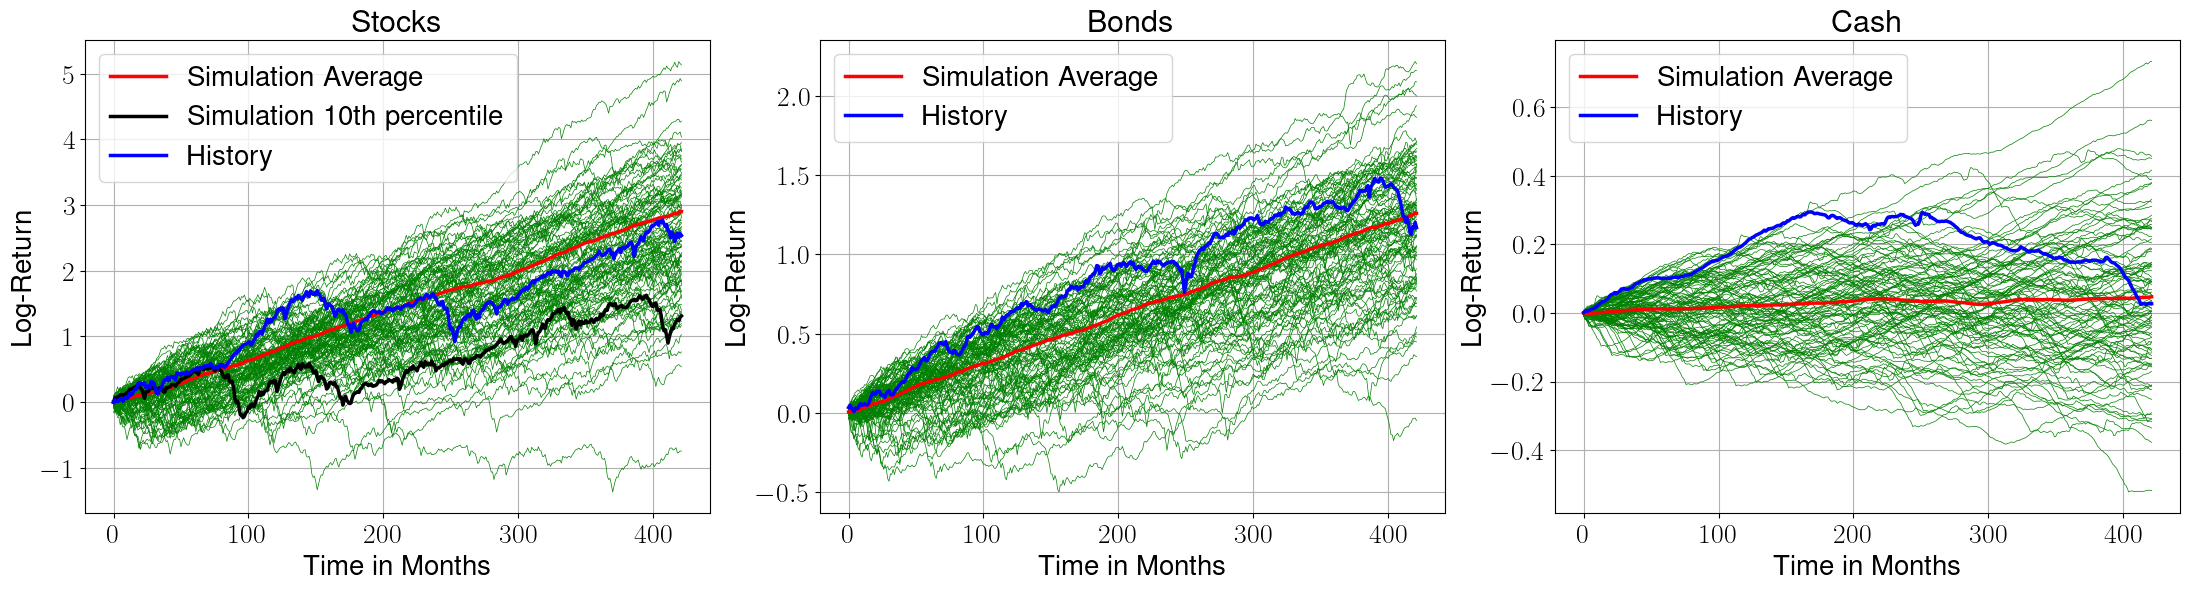

In [9]:
pe_final=((1+pe).cumprod(axis=0)-1).values[-1]
ix_bottom10=pe_final.argsort()[len(pe_final)//10]

_,ax=plt.subplots(1,3,figsize=(22,6))
ax[0].set_title('Stocks',fontsize=22)
ax[0].plot(np.log((1+pe).cumprod(axis=0)),linewidth=0.5,c='g')
ax[0].plot(np.log((1+np.mean(pe,axis=1)).cumprod()),linewidth=2.5,c='r',label='Simulation Average')
ax[0].plot(np.log((1+pe.iloc[:,ix_bottom10]).cumprod(axis=0)),linewidth=2.5,c='k',label='Simulation 10th percentile')
ax[0].plot(np.log((1+returns_data_infl[:,0]).cumprod()),linewidth=2.5,c='b',label='History')
ax[0].grid(True)
ax[0].tick_params(labelsize=20)
ax[0].legend(fontsize=20)
ax[0].set_xlabel('Time in Months',fontsize=20)
ax[0].set_ylabel('Log-Return',fontsize=20)

ax[1].set_title('Bonds',fontsize=22)
ax[1].plot(np.log((1.0+pb).cumprod(axis=0)),linewidth=0.5,c='g')
ax[1].plot(np.log((1.0+np.mean(pb,axis=1)).cumprod()),linewidth=2.5,c='r',label='Simulation Average')
ax[1].plot(np.log((1+returns_data_infl[:,1]).cumprod()),linewidth=2.5,c='b',label='History')
ax[1].grid(True)
ax[1].tick_params(labelsize=20)
ax[1].legend(fontsize=20)
ax[1].set_xlabel('Time in Months',fontsize=20)
ax[1].set_ylabel('Log-Return',fontsize=20)


ax[2].set_title('Cash',fontsize=22)
ax[2].plot(np.log((1.0+pf).cumprod(axis=0)),linewidth=0.5,c='g')
ax[2].plot(np.log((1.0+np.mean(pf,axis=1)).cumprod()),linewidth=2.5,c='r',label='Simulation Average')
ax[2].plot(np.log((1+returns_data_infl[:,2]).cumprod()),linewidth=2.5,c='b',label='History')
ax[2].grid(True)
ax[2].tick_params(labelsize=20)
ax[2].legend(fontsize=20)
ax[2].set_xlabel('Time in Months',fontsize=20)
ax[2].set_ylabel('Log-Return',fontsize=20)


#plt.suptitle("Net of inflation log returns",fontsize=24)
plt.tight_layout()
plt.show()


## Problem Set Up

Given at time $t=0$:

- MC paths of $e_t$ (equities), $b_t$ (bonds) and $z_t$ (risk-free) returns
- Goals $g_t$ to be funded for $t=[1,2,...T]$ (inflation-adjusted into the future using today's expectations)
- Incoming cashflows $c_t$ for $t=[1,2,...T]$ (inflation-adjusted into the future using today's expectations)

we would like to evaluate:

1. Starting _minimum_ required wealth $W(t)=W_0$ and
2. Corresponding optimal investment allocation policy $\mathbf{w}_t$ $=(\text{equities}=u_t,\text{bonds}=v_t, \text{cash}=1-u_t-v_t)$,  where the weights at all times are bounded by 0 and 1 (no leverage constraint).

Minimizing the starting wealth  requires making the most use of the expected growth of investments by allocating them across equities and bonds. Since investments are stochastic, the optimality condition reflects the balance between higher risk necessary to achieve higher expected growth rate with necessity to have lowest risk on the amounts that need to be paid out at any given period or in the immediate future. 

Given probability distribution of future returns, we establish a requirement for the minimum wealth to be such that probability of funding the goals will be at the chosen threshold $p_0$. A common convention in the industry is to set $p_0=90\%$, however the number can (and should be) be varied if goals of different priorities are introduced. 

## Evolution of wealth

We can now describe the general problem using the language of stochastic processes. At time $t=0$ we have a starting wealth $W_0$. During times $0<t<T$ we receive income contributions $i_t$ while paying out expenses $x_t$ and when needed  goals $g_t$, where $i_t$, $x_t$ and $g_t$ are non-negative by convention. At the end of each time step $t$ the total wealth $W_t$ is distributed across equities and bonds in proportions $u_t$ and $v_t$ respectively, with remainder allocated to cash.

In continuous time notation we can write down stochastic process for the wealth as follows:

\begin{equation}\label{eq:wealth_stoch}
dW_t=f_t dt + W_tdR_t(u,v)
\end{equation}

where we set $f_t=i_t-x_t-g_t$, and defined stochastic process for the instantaneous return $dR_t(u,v)$ of a unit allocation portfolio using
\begin{equation}\label{eq:ret}
dR_t(u,v) = u_tde_t+v_tdb_t+(1-u_t-v_t)dc_t
\end{equation}

A big simplification is disallowance of negative wealth levels. Having all goals funded on any particular Monte-Carlo path is equivalent in these notations to avoiding the *absorbing boundary* at $W=0$. 
Our objective is to find optimal allocation trajectories allowing for smallest starting wealth $W_0$ such that only the prespecified number of wealth trajectories end up hitting that boundary.

## Estimating optimal rebalancing policy and required starting wealth

Let us formalize procedure of finding optimal rebalancing policy and corresponding minimum required starting wealth. Given wealth evolution (\ref{eq:wealth_stoch}) we can solve corresponding Fokker-Plank equation for the probability $P(W_T | W_0)$ with absorbing boundary at $W_t=0$ $\forall t$. We then write down an implicit relationship between $W_0$ and the rebalancing policy $(u,v)$ by demanding all the goals be funded with probability $p_0$ which is equivalent to having terminal wealth be above 0:

\begin{equation}\label{eq:prob_funding}
\int_0^{\infty} dW_T P(W_T | W_0) = p_0
\end{equation}

Using Monte-Carlo simulations, for each rebalancing policy $(u,v)$ we can easily solve this equation for the value of $W_0=W_0(u,v)$ using a straightforward one-dimensional root search, which puts us in a position to formulate and solve the final optimization problem

\begin{equation}\label{eq:minw_opt_general}
W_0^* = \underset{u, v}{\text{min}} W_0(u, v)
\end{equation}

whose solution will produce both the required starting wealth as well the projected rebalancing policy to follow.

To gain intuition let us consider the simplest possible example: 
- Beginning wealth $W_0$, no further contributions.
- Single goal $G$ at the end of the life $t=T$ ($f_t=0 \forall t<T\, f(T)=-G$). 
- Normally distributed returns for all three assets $de_t$,$db_t$,$dc_t$.  

In this case the wealth evolution eq. (\ref{eq:wealth_stoch}) simplifies to ordinary log-normal process for which we can easily evaluate the terminal probability distribution as 

\begin{equation}\label{eq:prob_single}
P(W_T=W|W_0) = N_{pdf}\left(\frac{\ln(W/W_0)-M_T}{\Sigma_T}\right)
\end{equation}

where $N_{pdf}$ is a standard normal density function, and $M_T$ and $\Sigma_T$ are the mean and standard deviation dependent on the allocation trajectories $u$ and $v$ accumulated towards the end.

$$
M_T = \int_0^Tdt \left(\mu_R(u_t,v_t)-\frac{1}{2}\sigma_R^2(u_t,v_t)\right)\\
$$

$$
\Sigma^2_T = \int_0^Tdt \sigma_R^2(u_t,v_t)
$$

From this formula we can easily estimate the total probability that the amount of wealth at time $T$ will be above the threshold $G$:

\begin{equation}\label{eq:prob_single_cdf}
P(W_T>G|W_0) = \int_{\frac{\ln(G/W0)-M_T}{\Sigma_T}}^{\infty} \frac{dx}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2} = 1 - N_{cdf}\left(\frac{\ln(G/W_0)-M_T}{\Sigma_T}\right)
\end{equation}


Setting the left hand side of eq. (\ref{eq:prob_single_cdf}) to the desired level $p_0$ we solve the equation for the value of $W_0$:

$$
-N_{cdf}^{-1}(p_0)=\frac{\ln(G/W_0)-M_T}{\Sigma_T}\nonumber\\
\\
W_0(u,v) = G\exp\left(-M_T(u,v) + \gamma_0\Sigma_T(u,v)\right)
$$
where $\gamma_0=N_{cdf}^{-1}(p_0)$.

Intuitively the above expression is very clear: the value of starting wealth $W_0$ decreases with increase in the average portfolio growth rate $M_T$, and decreases with the corresponding increase in portfolio risk $\Sigma_T$.

## Aggregate monthly returns into annual

In [10]:
ann_paths=None
use_freq=1
tmp=pd.DataFrame(np.column_stack((paths_model[:,0,:],paths_model[:,1,:],paths_model[:,2,:])))
tmp.loc[:,'y']=np.arange(paths_model.shape[0])//12
tmp_ann=tmp.groupby('y').apply(lambda x: (1.0+x).prod(axis=0)-1.0).drop('y',axis=1)
p1=tmp_ann.values[:,:N_paths]
p2=tmp_ann.values[:,N_paths:2*N_paths]
p3=tmp_ann.values[:,2*N_paths:]  
T_y=p1.shape[0]
ann_paths=np.zeros((T_y,3,N_paths))
ann_paths[:,0,:]=p1
ann_paths[:,1,:]=p2    
ann_paths[:,2,:]=p3
print(ann_paths.shape)
mu_ann=mu*12
Co_ann=Co*np.sqrt(12)
print(mu_ann)
print(Co_ann)
print(freq)


(60, 3, 10000)
[0.08340533 0.03498335 0.00083107]
[[6.32330049e-03 9.36657812e-04 3.36015148e-05]
 [9.36657812e-04 9.68041765e-04 5.05410408e-05]
 [3.36015148e-05 5.05410408e-05 3.28409238e-05]]
12


In [11]:
print('GARCH simulation - annual aggregations')
display(calc_stats([ann_paths[:,0,:],ann_paths[:,1,:],ann_paths[:,2,:]],freq=1).style.format('{:.1%}'))

GARCH simulation - annual aggregations


In [12]:
def mortgage_payment(rate,term,freq=12):
    r = rate/12.
    p = r*((1+r)**(term*12))/((1+r)**(term*12)-1)
    return p*12./freq

In [13]:
# avatar set-up
state='CA'
age=35
death=90
T_run=death-age
retire=67
kid_age=6
house=age+2
college=age+19-kid_age
college_dur=4
retire_ix =  np.arange((retire-age)*use_freq,T_run*use_freq)
house_ix  =  [(house-age)*use_freq]
college_ix=  np.arange((college-age)*use_freq,(college-age+college_dur)*use_freq)
ann_income=1.5
ann_expenses=1.2
college_ann_cost=.75
retire_spend = ann_expenses
house_value = 7.5
downpayment = house_value * 0.2
house_carry = 0.015
mortgage_rate=0.06
mortgage_term=30
house_payment = (house_value-downpayment)*mortgage_payment(mortgage_rate,mortgage_term,freq=use_freq)+house_value*house_carry
house_payments_ix = np.arange((house-age)*use_freq,min((house-age+mortgage_term)*use_freq,T_run*use_freq))
current_savings=5.5

income=np.zeros(T_run)
income[:retire_ix[0]]=ann_income
spend=np.zeros(T_run)
spend[:retire_ix[0]]=ann_expenses
inflows=income-spend

retirement_lump_goal=np.zeros(T_run)
retirement_lump_goal[retire_ix[0]]=len(retire_ix)*retire_spend

retirement_goal=np.zeros(T_run)
retirement_goal[retire_ix]=retire_spend

house_goal=np.zeros(T_run)
house_goal[house_ix]=downpayment
house_goal[house_payments_ix] += house_payment

college_goal=np.zeros(T_run)
college_goal[college_ix]=college_ann_cost

goal0=house_goal

goal1=retirement_goal

goal2=retirement_goal+house_goal

goals_a=house_goal+college_goal+retirement_goal

#### Create three distinct profiles

In [14]:
house_goal_obj=Cashflow(house_payments_ix,house_goal[house_payments_ix])
college_goal_obj=Cashflow(college_ix,college_goal[college_ix])
retirement_goal_obj=Cashflow(retire_ix,retirement_goal[retire_ix])
inflows_obj=Cashflow(np.array(range(retire_ix[0])),inflows[:retire_ix[0]])
min_spending_obj=Cashflow(retire_ix,0.8*retirement_goal[retire_ix])

alice=Profile([inflows_obj],
              [house_goal_obj,college_goal_obj,retirement_goal_obj],
              T_run,
              current_savings,
              min_spending_obj=min_spending_obj)

alice_hi=Profile([inflows_obj],
                 [college_goal_obj,retirement_goal_obj],
                 T_run,
                 current_savings,
                 min_spending_obj=min_spending_obj)

bob_age=57
bob_retire=60
T_run_bob=death-bob_age
bob_starting_wealth = 17.
bob_retirement_goal = Cashflow(range(bob_retire-bob_age,T_run_bob),2*np.ones(T_run_bob-(bob_retire-bob_age)))
bob_helicopter_goal = Cashflow([bob_retire-bob_age+1],np.array([5.]))
bob_legacy_goal = Cashflow(np.array([T_run_bob-1]),np.array([5.]))
bob_min_spending_obj= Cashflow(bob_retirement_goal.cf_ix,0.8*bob_retirement_goal.cf_values)

bob  =Profile([Cashflow(range(bob_retire-bob_age),
                        0.5*np.ones(bob_retire-bob_age))],
              [bob_retirement_goal,bob_helicopter_goal,bob_legacy_goal],
              T_run_bob,
              bob_starting_wealth,
              min_spending_obj=bob_min_spending_obj)

charlie_age=60
charlie_retire=62
T_run_charlie=death-charlie_age
charlie_starting_wealth = 13
charlie_submarine_goal = Cashflow([charlie_retire-charlie_age+1],np.array([12.]))
charlie_retirement_goal = Cashflow(range(charlie_retire-charlie_age,T_run_charlie),0.3*np.ones(T_run_charlie-(charlie_retire-charlie_age)))
charlie_min_spending_obj= Cashflow(charlie_retirement_goal.cf_ix,0.8*charlie_retirement_goal.cf_values)

charlie  =Profile([Cashflow(range(charlie_retire-charlie_age),0.5*np.ones(charlie_retire-charlie_age))],
                  [charlie_retirement_goal,charlie_submarine_goal],
                  T_run_charlie,
                  charlie_starting_wealth,
                  min_spending_obj=charlie_min_spending_obj)

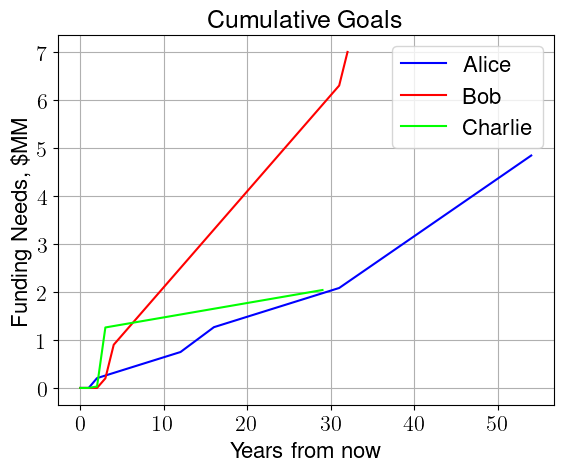

In [15]:
plt_data=np.nan*np.zeros((len(alice.goals),3))
plt_data[:,0]=alice.goals.cumsum()/10
plt_data[:len(bob.goals),1]=bob.goals.cumsum()/10
plt_data[:len(charlie.goals),2]=charlie.goals.cumsum()/10
pd.DataFrame(plt_data,columns=['Alice','Bob','Charlie'],index=range(T_run)).plot(grid=True,color=['b','r','lime'])
plt.xlabel('Years from now',fontsize=16)
plt.ylabel('Funding Needs, \$MM',fontsize=16)
plt.legend(fontsize=16)
plt.title('Cumulative Goals',fontsize=18)
plt.tick_params(labelsize=16)
plt.show()

In [16]:
def sim_pct(w0,pol,paths,inflows,probs):
    T=paths.shape[0]
    g=goal_single(T-1,T)
    _,_,wp,_,_,_,_=simulate_wealth(paths,g,inflows,pol,w0)
    return [np.percentile(wp,100.0*(1-p),axis=1) for p in probs],np.diff(wp,axis=0).std(axis=0).mean()

## Shape of 90th percentile over time for each of the assets

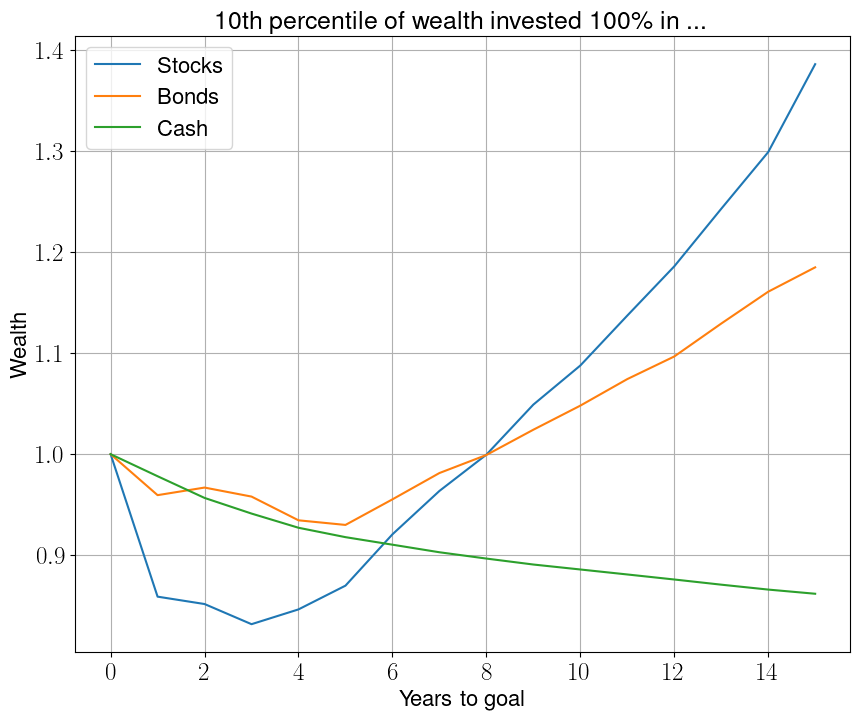

In [17]:
t_obj=15
p1=np.repeat(np.array([1,0,0]).reshape((1,3)),t_obj,axis=0)
p2=np.repeat(np.array([0,1,0]).reshape((1,3)),t_obj,axis=0)
p3=np.repeat(np.array([0,0,1]).reshape((1,3)),t_obj,axis=0)
pcts=[sim_pct(1.0,pol,ann_paths[:t_obj],np.zeros(t_obj),[0.9])[0][0] for pol in [p1,p2,p3]]
pd.DataFrame(np.column_stack(pcts),
             columns=['Stocks','Bonds','Cash'],
             index=np.arange(0,t_obj+1)).plot(grid=True,fontsize=18,figsize=(10,8))
plt.xlabel('Years to goal',fontsize=16)
plt.ylabel('Wealth',fontsize=16)
plt.legend(fontsize=16)
plt.title('10th percentile of wealth invested 100\% in ...',fontsize=18)
plt.show()

#### It appears before ~1.5y time being invested in risk-free asset will have your real dollars hit the target with most certainty, and after about 8y we want to be mostly in stocks.
Let's create a glidepath with elbow around 5y and about 4y transition.

In addition lets characterize each portfolio risk by its ex-ante value based on the annualized covariance matrix as well as by its sensitivity to having a 1\% error in estimation of the historical mean of stock returns. 

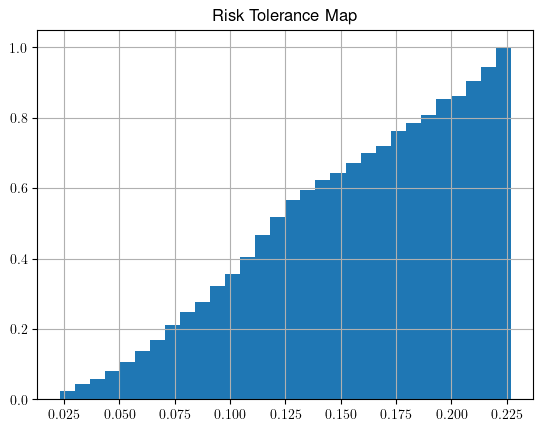

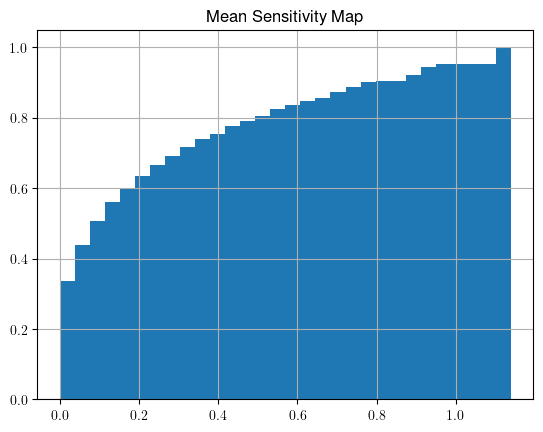

In [18]:
random1000=np.random.choice(range(10000),1000,replace=False)
grid_size=20
grid_step=1./grid_size

# optimal allocations for each horizon - u=v=0 correspponds to 100% cash
uu=np.zeros(T_run)
vv=np.zeros(T_run)
uf=np.zeros(T_run)
vf=np.zeros(T_run)

risk_dist=np.zeros((grid_size+1,grid_size+1))
risk_sens=np.zeros((grid_size+1,grid_size+1))
ann_paths_less=ann_paths.copy()
ann_paths_less[:,0,:] -= 0.01
for i in range(grid_size+1):
    u=i*grid_step
    for j in range(grid_size+1):
        v=j*grid_step
        w = np.repeat(np.array([u,(1-u)*v,(1-u)*(1-v)]).reshape((1,3)),T_run,axis=0)
        r = (w[:,:,np.newaxis]*ann_paths[:T_run]).sum(axis=1)
        r_less = (w[:,:,np.newaxis]*ann_paths_less[:T_run]).sum(axis=1)
        wp = (1+r).cumprod(axis=0)
        wp_less = (1+r_less).cumprod(axis=0)
        wp10 = np.percentile(wp,90,axis=1)
        wp10_less = np.percentile(wp_less,90,axis=1)
        A=np.vstack([np.arange(T_run), np.ones(T_run)]).T
        m, c = np.linalg.lstsq(A, wp10-wp10_less, rcond=None)[0]
        #risk_dist[i,j] = np.sqrt(np.matmul(w,np.matmul(Co_ann,w.T)))
        risk_dist[i,j] = np.percentile(-r[r<0],80,axis=0).mean()
        risk_sens[i,j] = m

risk_dist_data=risk_dist.reshape(((grid_size+1)**2,))
_,ax=plt.subplots()
ax.hist(risk_dist_data,bins=30,cumulative=True,density=True)
ax.grid()
ax.set_title('Risk Tolerance Map')
plt.show()
        
    
risk_sens_data=risk_sens.reshape(((grid_size+1)**2,))
_,ax=plt.subplots()
ax.hist(risk_sens_data,bins=30,cumulative=True,density=True)
ax.grid()
ax.set_title('Mean Sensitivity Map')
plt.show()    

0.12497290580281067


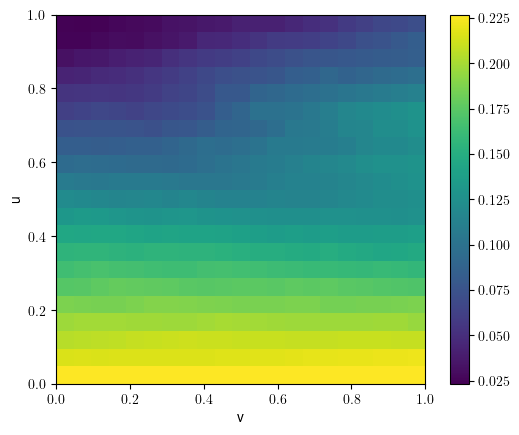

In [19]:
risk_thr = lambda x: risk_dist_data.min() + (risk_dist_data.max()-risk_dist_data.min())*x 
risk_tolerance = 0.5
print(risk_thr(risk_tolerance))
risk_mask = risk_dist<risk_thr(risk_tolerance)
_,ax=plt.subplots()
im=ax.imshow(risk_dist,extent=(0,1,0,1))
ax.set_xlabel('v')
ax.set_ylabel('u')
plt.colorbar(im)
plt.show()

\section{Define candidate policy as a convolution of bullet glide path with goals time series}

Parameter vector: $ \mathbf{x} = \left(\tau_s ,t_x,\tau_b \right) $

that defines $t=0$ allocation vector for a goal of size $\$1$ at time $t$:     

\begin{equation*}
\text{Stocks}_t = \frac{1}{2}\left(1+\tanh \left( \frac{t - t_x}{\tau_s } \right)\right) \\ 
\text{Bonds}_t   = \left(1 - \text{Stocks}_t\right)\cdot\tanh\left(\frac{t}{\tau_b}\right) \\
\text{Cash}_t  = \left(1 - \text{Stocks}_t\right)\cdot\left(1 - \tanh\left(\frac{t}{\tau_b}\right)\right)  \\   
\end{equation*}

#### From kernel to a given user glidepath

\begin{equation*}
GP_t[g_0\delta(t-t_0)] = K(t_0-t,\mathbf{x})
\end{equation*}


\begin{equation*}
GP_t[g] = \frac{\int_t^Tdt' K\left( t'-t,\mathbf{x}\right)\cdot g_{t'}}{\int_t^Tdt'g_{t'}}
\end{equation*}

#### Metrics to keep track of

$$
U_k = \frac{\sum_t\text{Goals}_t\cdot I^k_{W_t>0}}{\sum_t\text{Goals}_t} \\
U = \frac{1}{N}\sum_{k=1}^N U_k
$$

\begin{equation*}
P = \frac{1}{N}\sum_{k=1}^N I^k_{W_T>0}
\end{equation*}

\begin{equation*}
R_2 = \frac{\sum_k\text{std}\left(\Delta W^{k,inv}\right)}{N\sum_t{\text{Goals}_t}}\\ 
R_{max} = \frac{\sum_k\text{MaxDD}\left(\Delta W^{k,inv}\right)}{N\sum_t{\text{Goals}_t}} 
\end{equation*}

\begin{equation*}
T_0 = \frac{1}{N}\sum_{k=1}^N \frac{\min_t\left(W_t^k=0\right)}{T}
\end{equation*}

$$
P,\, U,\, \text{Risk},\, T_0 =F\left(\text{Income},\text{Expenses},W_0, \text{Goals}, \text{GP}\left[\text{Goals},K(\mathbf{x})\right],\text{Simulated Returns}\right)
$$

[ 5.  10.   1.5]


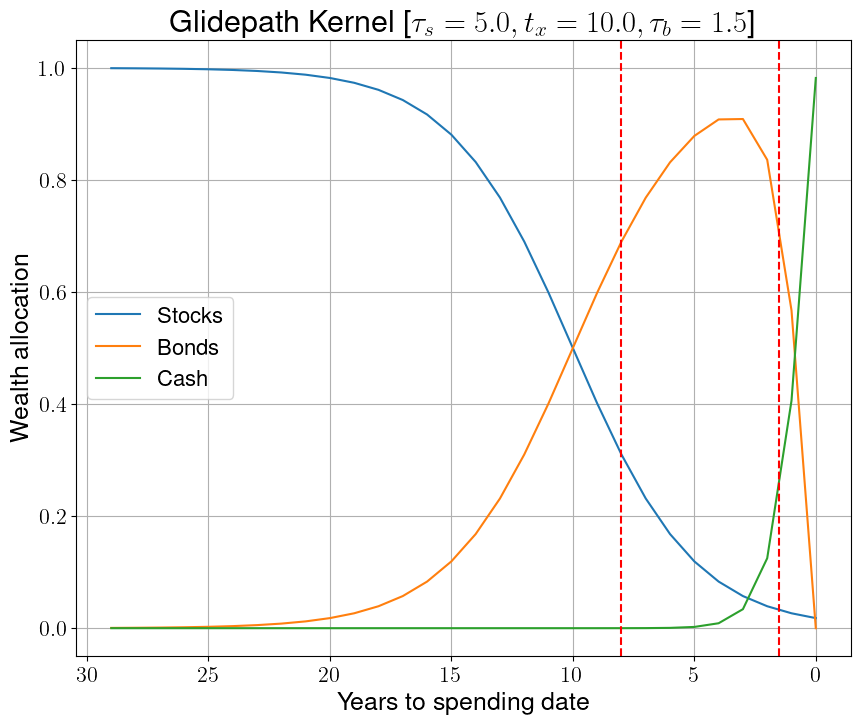

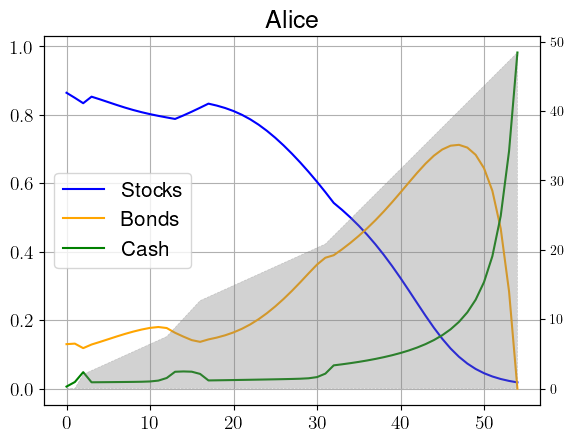

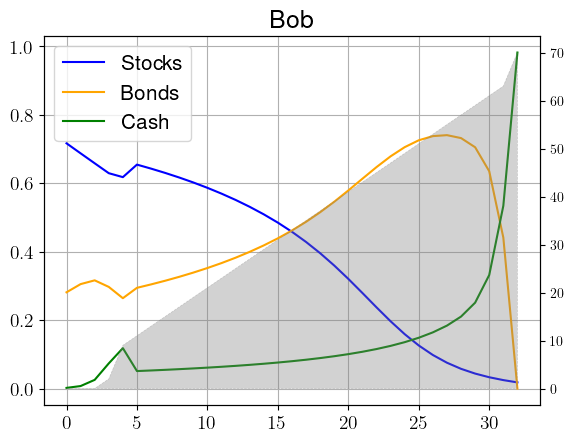

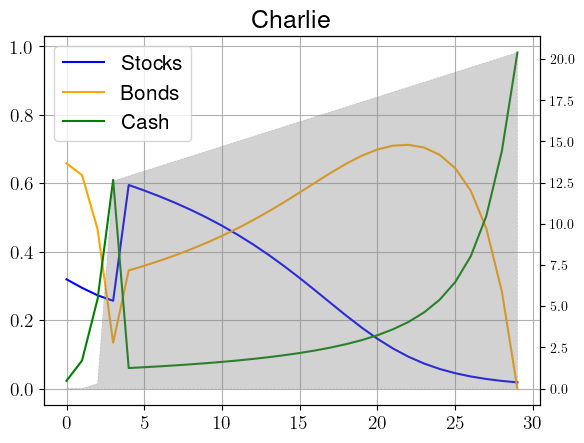

In [20]:
tau_s=5.
t_x=10.
tau_b=1.5
x_implied=np.array([tau_s,t_x,tau_b])
print(x_implied)
test_x=x_implied
gp=[]
for t in range(30):
    gp.append(gp_kernel(t,test_x))
_,ax=plt.subplots(figsize=(10,8))
pd.DataFrame(np.vstack(gp),columns=['Stocks','Bonds','Cash']).plot(ax=ax,grid=True,fontsize=16)
ax.axvline(1.5,color='r',linestyle='--')
ax.axvline(8,color='r',linestyle='--')
ax.legend(fontsize=16)
ax.set_xlabel('Years to spending date',fontsize=18)
ax.set_ylabel('Wealth allocation',fontsize=18)
ax.set_title(r'Glidepath Kernel [$\tau_s={:.1f}, t_x={:.1f}, \tau_b={:.1f}$]'.format(test_x[0],test_x[1],test_x[2]),fontsize=22)
ax.invert_xaxis()
ax.tick_params(labelsize=16)
plt.show()

test_goal=np.zeros(30)
test_goal[15]=1.

for profile,name in zip([alice,bob,charlie],['Alice','Bob','Charlie']):
    _,ax=plt.subplots()
    gp=pd.DataFrame(build_policy_for_goals(test_x,profile.goals),
                           columns=['Stocks','Bonds','Cash'])
    gp.plot(ax=ax,grid=True,color=['b','orange','g'],linewidth=1.5)
    ax.set_title('{}'.format(name),fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=15)
    axx=ax.twinx()
    axx.fill_between(range(len(profile.goals)),profile.goals.cumsum(),label='Funding Needs',linewidth=0.5,linestyle='--',color='grey',alpha=0.35)
    plt.show()


$$
\mathbf{\tau_s\approx 5},\,\mathbf{t_x\approx 10},\,\mathbf{\tau_b\approx 1.5}
$$

In [21]:
def avg_exit_time(wp):
    avg_run_out = np.int8(wp[1:]>0.).sum(axis=0)
    avg_run_out[avg_run_out==0]=wp.shape[0]-1
    avg_run_out = avg_run_out.mean()/(wp.shape[0]-1)
    return avg_run_out

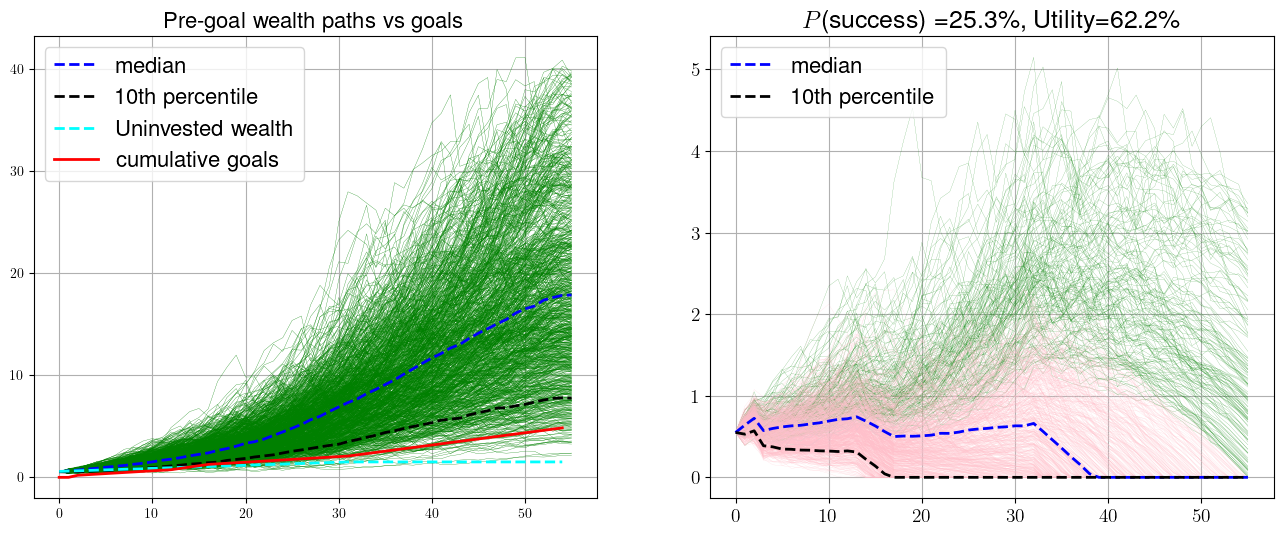

MDD 0.5396132072765946
RD 0.1545320283420642
$T_0$ 0.6897818181818183


In [22]:
result_alice=simulate_wealth_(ann_paths[:,:,random1000],
                              alice,
                              build_policy_for_goals(x_implied,alice.goals),
                              vis=True,
                              show_paths=True,
                              scale=0.1)
print('MDD', result_alice[4]/alice.goals.sum())
print('RD', np.diff(result_alice[2],axis=0).std(axis=0).mean()/alice.goals.sum())
print(r'$T_0$',avg_exit_time(result_alice[0]))

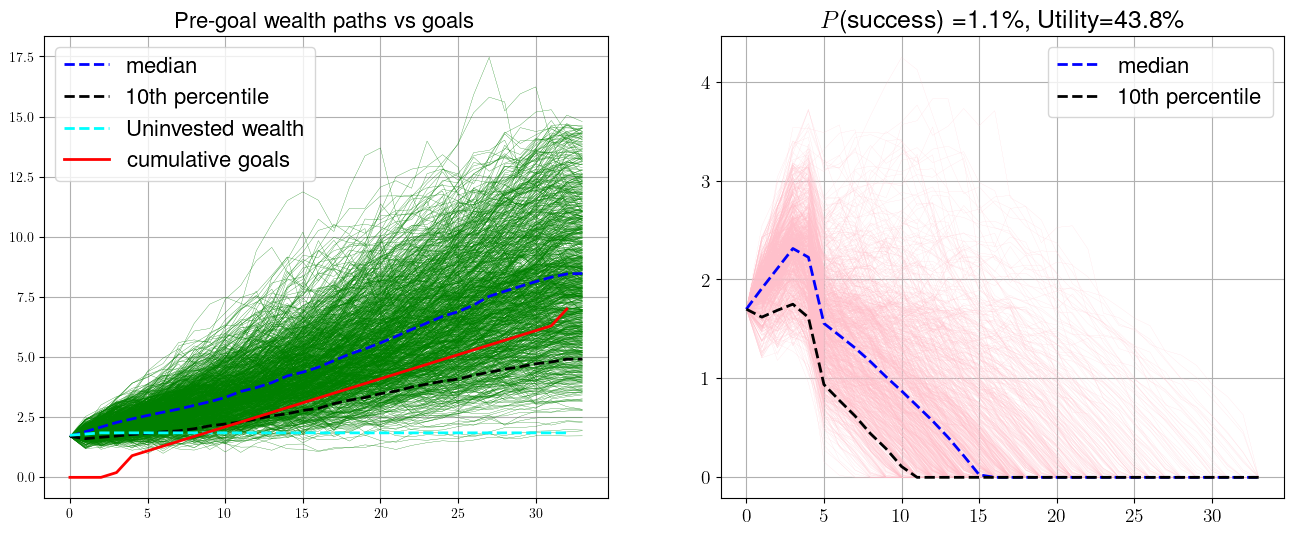

MDD 0.15017651509995203
RD 0.054457462732050786
$T_0$ 0.4787575757575757


In [23]:
result_bob=simulate_wealth_(ann_paths[:,:,random1000],
                            bob,
                            build_policy_for_goals(x_implied,bob.goals),
                            vis=True,
                            show_paths=True,
                            scale=0.1)
print('MDD', result_bob[4]/bob.goals.sum())
print('RD', np.diff(result_bob[2],axis=0).std(axis=0).mean()/bob.goals.sum())
print(r'$T_0$',avg_exit_time(result_bob[0]))

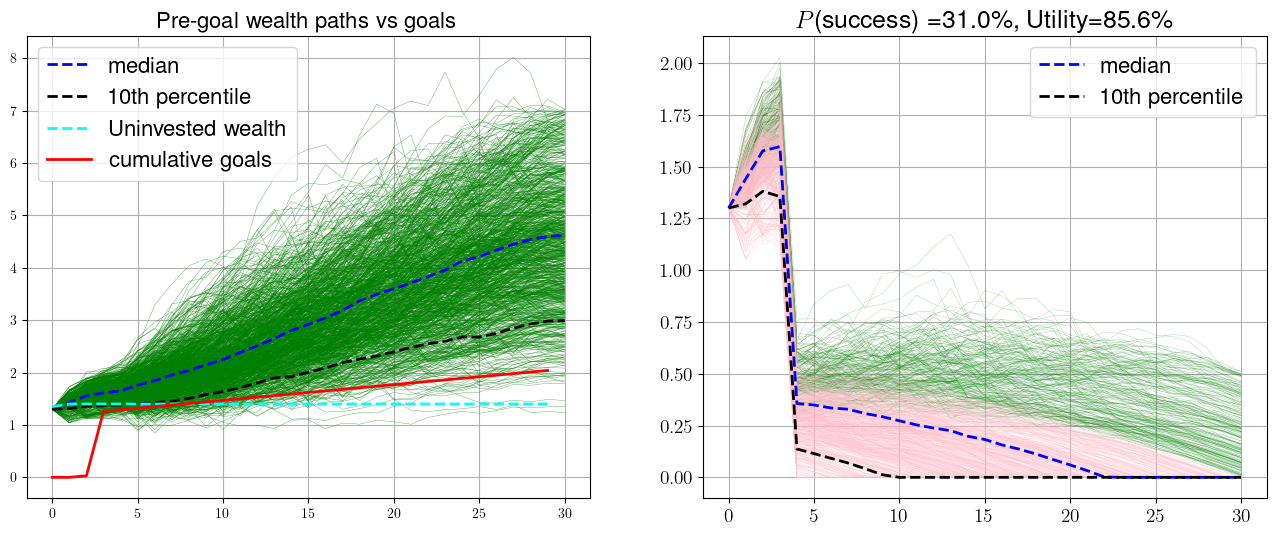

MDD 0.25723600155246296
RD 0.09590178394096645
$T_0$ 0.6964666666666666


In [24]:
result_charlie=simulate_wealth_(ann_paths[:,:,random1000],
                                charlie,
                                build_policy_for_goals(x_implied,charlie.goals),
                                vis=True,
                                show_paths=True,
                                scale=0.1)
print('MDD', result_charlie[4]/charlie.goals.sum())
print('RD', np.diff(result_charlie[2],axis=0).std(axis=0).mean()/charlie.goals.sum())
print(r'$T_0$',avg_exit_time(result_charlie[0]))

## Given policy and goals we can find the starting wealth targeting the required level of success probability

In [25]:
def evaluate(profile,policy,paths,vis=False,show_paths=False):
    result=simulate_wealth_(paths,
                            profile,
                            policy,
                            vis=vis,
                            show_paths=show_paths)
    
    prob = result[1]
    utility = result[3]
    utility_cond = result[6]
    mdd     = result[4]/(profile.starting_wealth+profile.inflows.sum())
    risk    = np.diff(result[2],axis=0).std(axis=0).mean()/(profile.starting_wealth+profile.inflows.sum())
    w0_req  = min_wealth_for_policy_(paths,profile,policy,0.9)
    wpg10   = np.percentile(result[0][1:],10,axis=1)
    wpg50   = np.percentile(result[0][1:],50,axis=1)
    run_out10 = min(np.nonzero(wpg10)[0][-1]+1,len(wpg10)-2)
    avg_run_out = np.int8(result[0][1:]>0.).sum(axis=0)
    avg_run_out[avg_run_out==0]=result[0].shape[0]-1
    avg_run_out = avg_run_out.mean()/(result[0].shape[0]-1)
    return np.array([w0_req,prob,utility,risk,mdd,run_out10,avg_run_out,utility_cond,policy[:,0].mean(axis=0)])

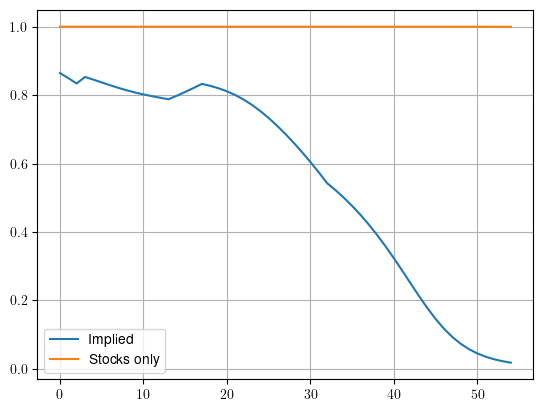

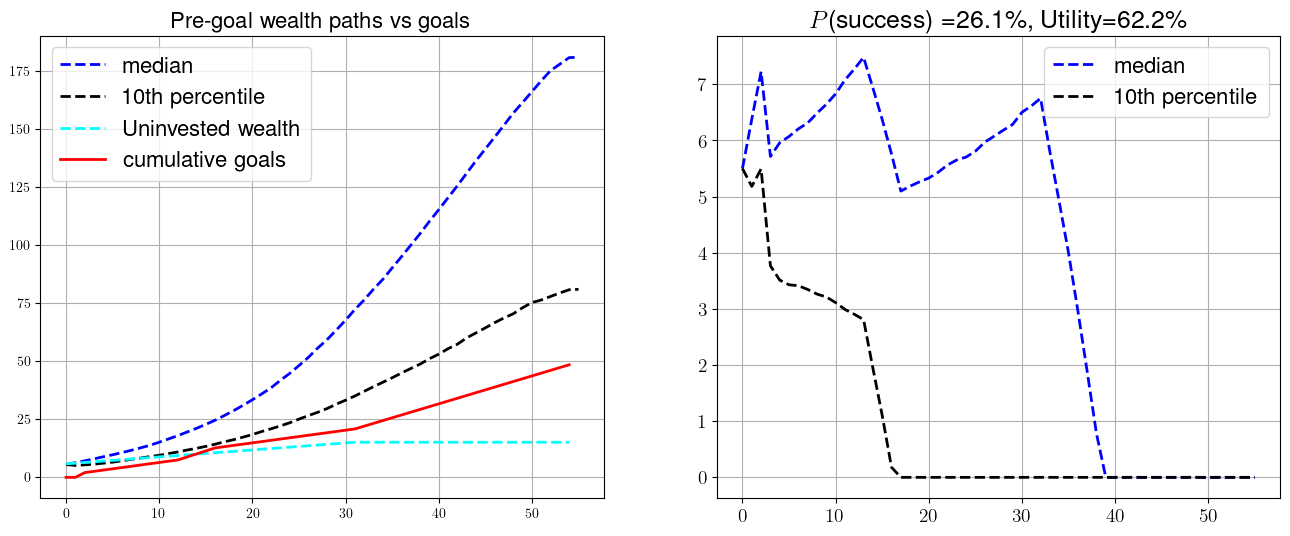

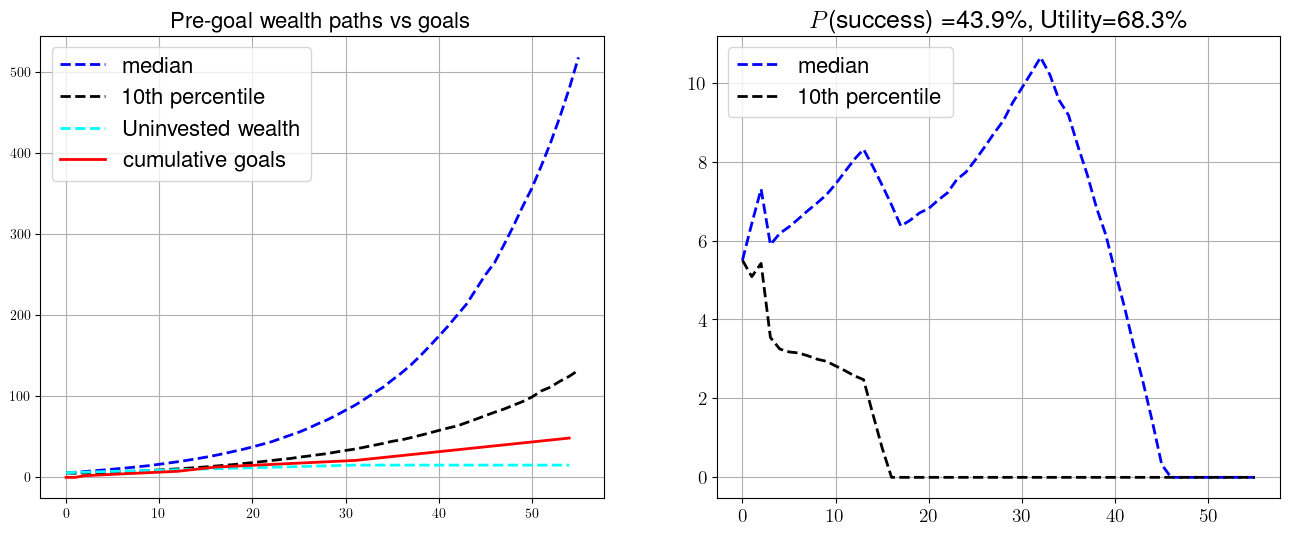

w0_req   prob      util      risk        mdd  run_out10  \
implied      9.127032  26.08  0.622141  0.496744   1.722846       16.0   
stocks only  8.843291  43.94  0.683254  2.912136  10.660329       15.0   

             avg_run_out  util cond  avg stocks weight  
implied         0.687507   0.675751           0.554727  
stocks only     0.733316   0.733670           0.999940

w0_req   prob      util      risk       mdd  run_out10  \
implied      10.498452  15.43  0.538822  0.398131  1.436801       15.0   
stocks only  10.687613  30.02  0.593316  1.907009  7.649583       15.0   

             avg_run_out  util cond  avg stocks weight  
implied         0.614355    0.60117           0.554727  
stocks only     0.655424    0.65643           0.999940

In [26]:
random1000=np.random.choice(range(10000),1000,replace=False)
gp_implied = build_policy_for_goals(x_implied,alice.goals)
gp_stox_only = build_policy_for_goals(x_implied*np.array([1,-2,1]),alice.goals)
pd.DataFrame({'Implied':gp_implied[:,0],
              'Stocks only':gp_stox_only[:,0]}).plot(grid=True)
plt.show()


paths_less=ann_paths.copy()
paths_less[:,0,:] -= 0.01

out_comp=pd.DataFrame(np.vstack([evaluate(alice,policy,ann_paths[:T_run],vis=True) for policy in [gp_implied,gp_stox_only]]),
                      columns=['w0_req','prob','util','risk','mdd','run_out10','avg_run_out','util cond','avg stocks weight'],
                      index=['implied','stocks only'])
out_comp_less=pd.DataFrame(np.vstack([evaluate(alice,policy,paths_less[:T_run]) for policy in [gp_implied,gp_stox_only]]),
                           columns=['w0_req','prob','util','risk','mdd','run_out10','avg_run_out','util cond','avg stocks weight'],
                           index=['implied','stocks only'])

display(out_comp)
display(out_comp_less)

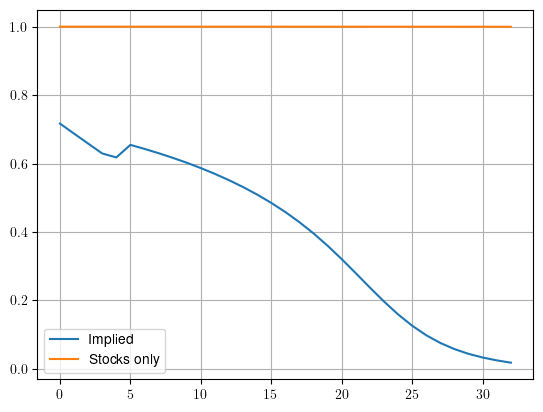

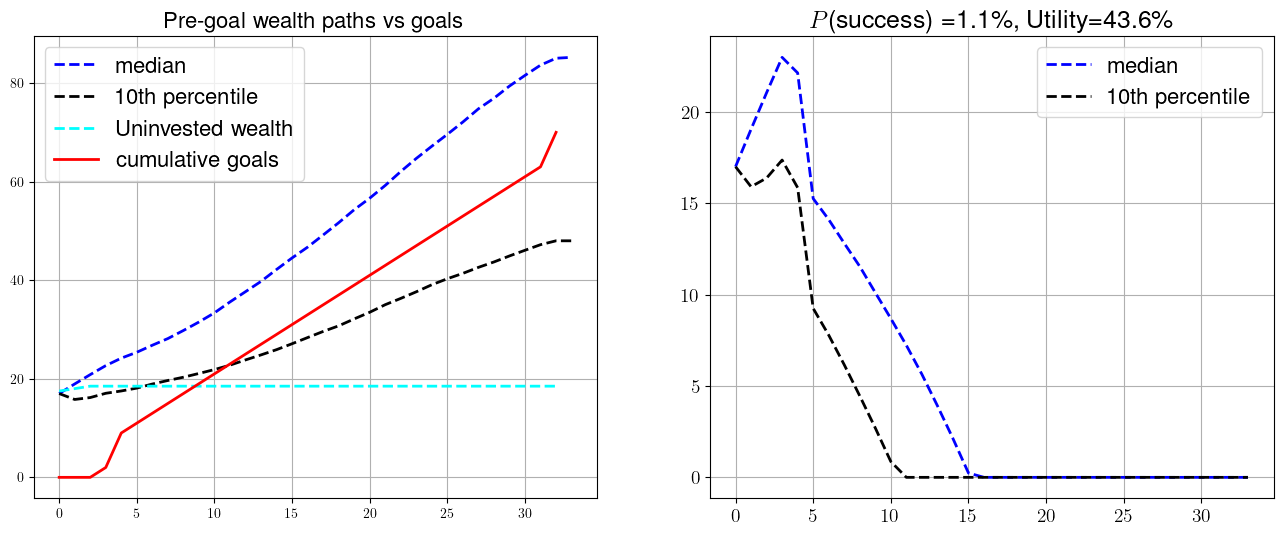

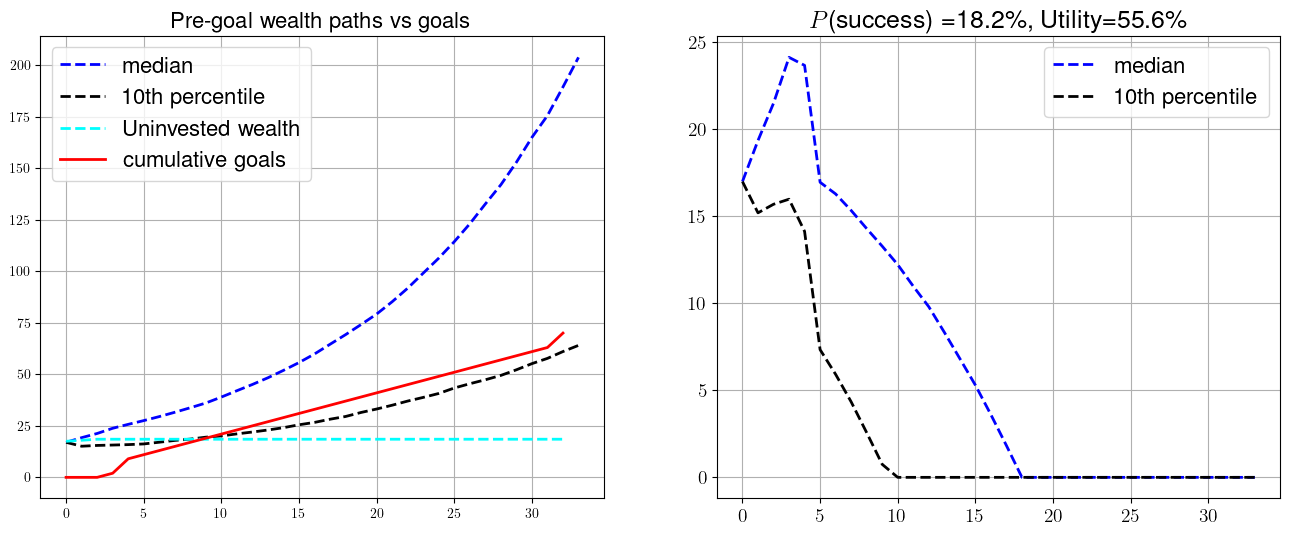

w0_req   prob      util      risk       mdd  run_out10  \
implied      32.539062   1.12  0.436499  0.208868  0.580878       10.0   
stocks only  31.445312  18.25  0.555967  1.001203  2.956633        9.0   

             avg_run_out  util_cond  avg stocks weight  
implied         0.477264   0.488854           0.393946  
stocks only     0.591109   0.615983           0.999920

In [27]:
gp_bob_implied = build_policy_for_goals(x_implied,bob.goals)
gp_bob_stox_only = build_policy_for_goals(x_implied*np.array([1,-2,1]),bob.goals)
pd.DataFrame({'Implied':gp_bob_implied[:,0],'Stocks only':gp_bob_stox_only[:,0]}).plot(grid=True)
plt.show()

out_comp_bob=pd.DataFrame(np.vstack([evaluate(bob,policy,ann_paths,vis=True) for policy in [gp_bob_implied,gp_bob_stox_only]]),
                          columns=['w0_req','prob','util','risk','mdd','run_out10','avg_run_out','util_cond','avg stocks weight'],
                          index=['implied','stocks only'])
display(out_comp_bob)

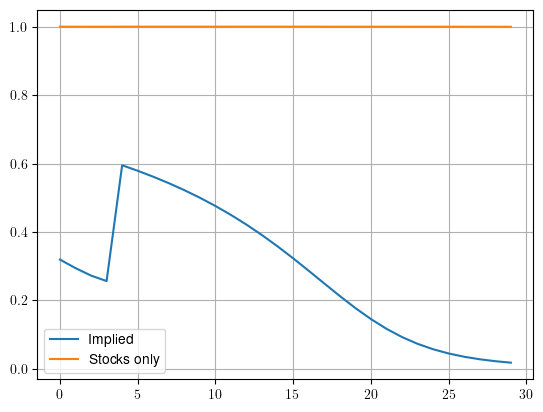

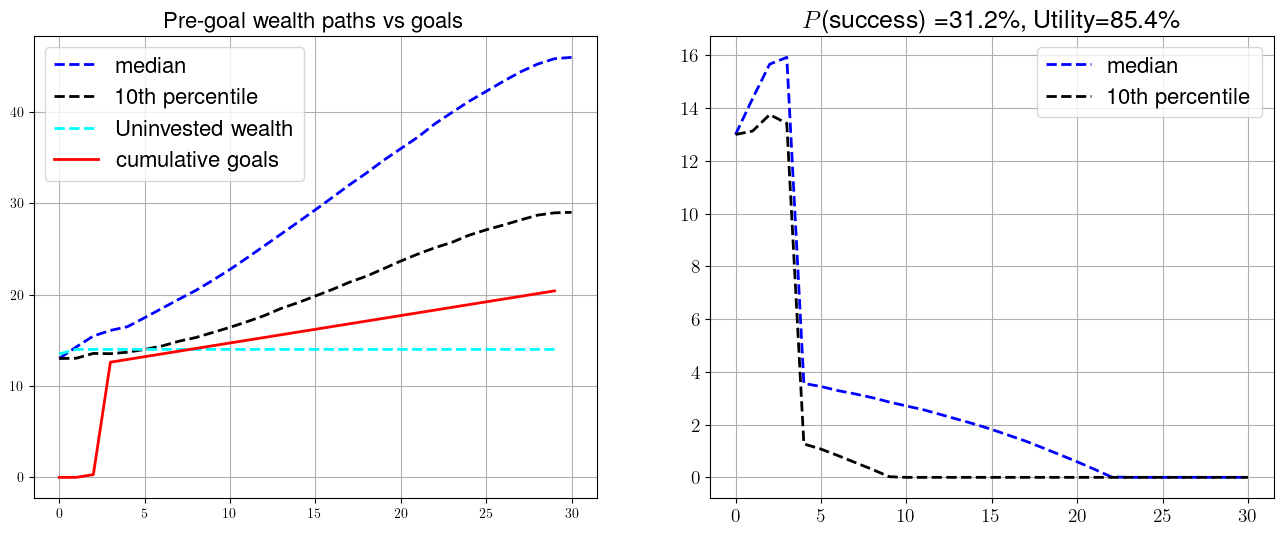

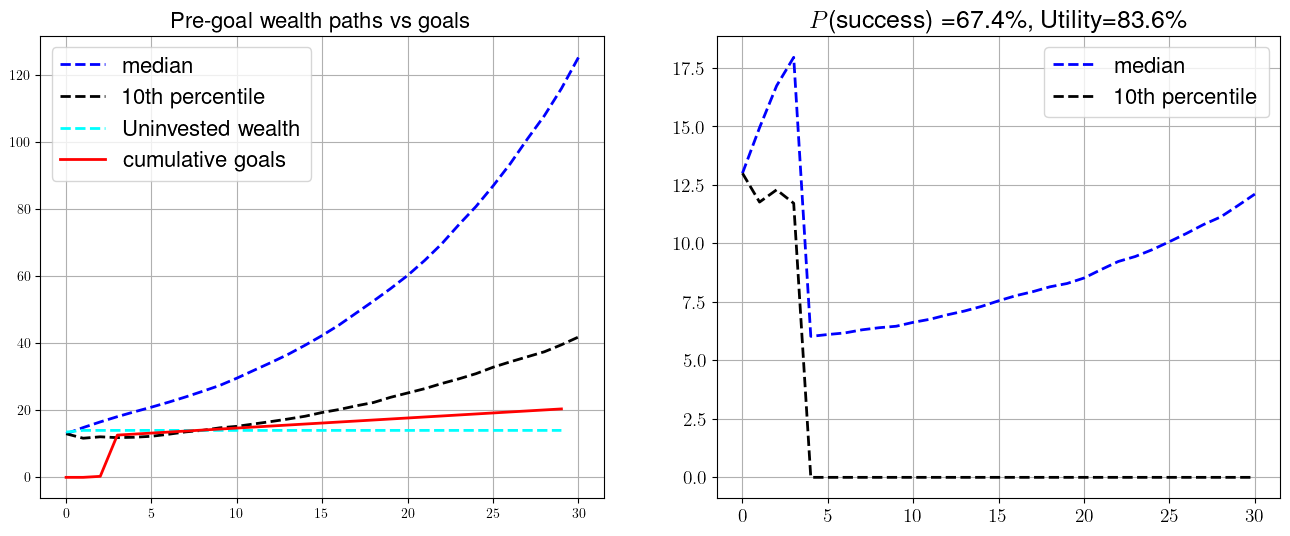

w0_req   prob      util      risk       mdd  run_out10  \
implied      13.626563  31.19  0.854353  0.141241  0.382667        9.0   
stocks only  14.901563  67.42  0.836232  0.810189  2.312651        3.0   

             avg_run_out  util cond  avg stocks weight  
implied         0.693867   0.873237           0.280703  
stocks only     0.789327   0.884491           0.999889

In [28]:
gp_charlie_implied = build_policy_for_goals(x_implied,charlie.goals)
gp_charlie_stox_only = build_policy_for_goals(x_implied*np.array([1,-2,1]),charlie.goals)
pd.DataFrame({'Implied':gp_charlie_implied[:,0],
              'Stocks only':gp_charlie_stox_only[:,0]}).plot(grid=True)
plt.show()

out_comp_charlie=pd.DataFrame(np.vstack([evaluate(charlie,policy,ann_paths,vis=True) for policy in [gp_charlie_implied,gp_charlie_stox_only]]),
                              columns=['w0_req','prob','util','risk','mdd','run_out10','avg_run_out','util cond','avg stocks weight'],
                              index=['implied','stocks only'])
display(out_comp_charlie)

## Plot dependencies on goal scale.

Can be easily replicated to observe monotonic dependence on $W_0$ or the amount of Inflows.

In [29]:
p_names=['Alice','Bob','Charlie']
p_data={pn:[] for pn in p_names}
for scale in np.linspace(0.2,2,10):
    for pn,profile in zip(p_names,[alice,bob,charlie]):
        profile_tmp=copy.copy(profile)
        profile_tmp.goals = profile.goals*scale
        p_data[pn].append(evaluate(profile_tmp,
                                   build_policy_for_goals(x_implied,
                                                          profile_tmp.goals),
                                   ann_paths,
                                   vis=False))
                          

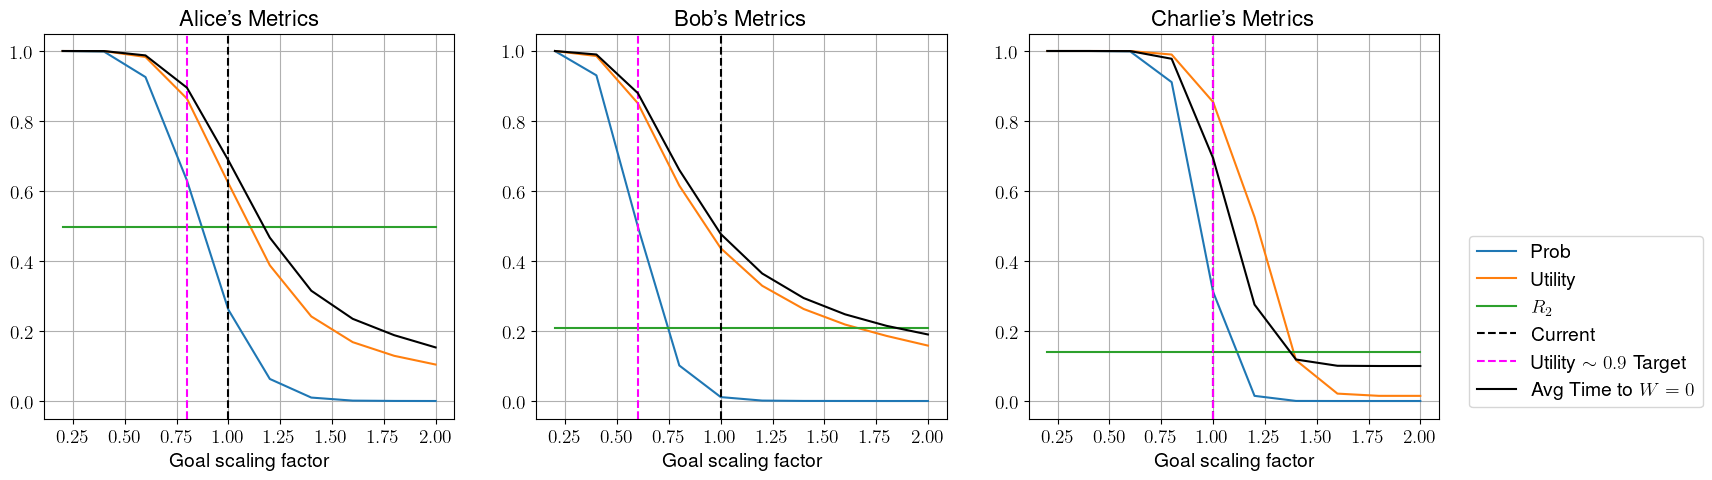

In [30]:
_,axs=plt.subplots(1,3,figsize=(18,5))
for pn,pr,ax in zip(p_data.keys(),[alice,bob,charlie],axs):
    w0_dep=pd.DataFrame(np.vstack(p_data[pn]),
                 index=np.linspace(0.2,2,10),#index=pr.starting_wealth*np.linspace(0.5,2,20),
                 columns=['W_0 req','Prob Pct','Utility','R_2','R_{max}','Run Out 10pct','Avg Time Run Out','Utility conditional','Avg Stocks Weight'])

    w0_dep['Prob'] = w0_dep['Prob Pct']/100.

    w0_dep[['Prob','Utility']].plot(ax=ax,grid=True,fontsize=14,legend=False)
    w0_dep['R_2'].plot(ax=ax,label='$R_2$')
    #w0_dep['R_{max}'].plot(ax=ax,label='$R_{max}$')
    ax.grid()
    ax.set_title("{}'s Metrics".format(pn),fontsize=16)
    ax.set_xlabel('Goal scaling factor',fontsize=14)
    #ax.set_xlabel('Starting Wealth, x\$100K',fontsize=14)
    ax.axvline(1,color='k',linestyle='--',label='Current')
    target=w0_dep.index[((w0_dep['Utility'].values-0.9)**2).argmin()]
    ax.axvline(target,color='magenta',linestyle='--',label='Utility $\sim 0.9$ Target')
    ax.plot(w0_dep['Avg Time Run Out'],color='k',label='Avg Time to $W=0$')
    if pn=='Charlie':
        ax.legend(fontsize=14,bbox_to_anchor=(1.05,0.5))
plt.show()

In [31]:
p_data_tx={pn:[] for pn in p_names}
tx_set=x_implied[1]*np.linspace(-1,1.5,26)
pol=[]
for tx in tx_set:
    for pn,profile in zip(p_names,[alice,bob,charlie]):
        gp=build_policy_for_goals(np.array([x_implied[0],tx,x_implied[2]]),profile.goals)
        if pn=='Alice':
            pol.append(gp)
        p_data_tx[pn].append(evaluate(profile,gp,ann_paths,vis=False))
                          

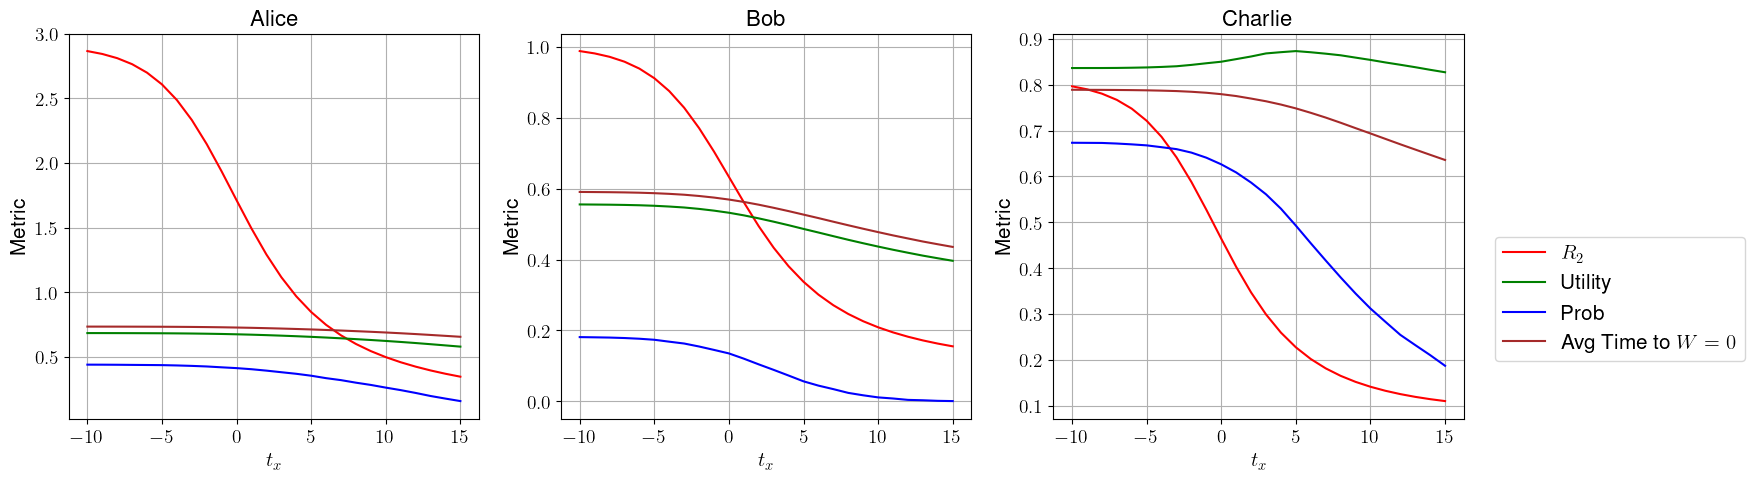

In [32]:
_,axs=plt.subplots(1,3,figsize=(18,5))
for pn,pr,ax in zip(p_names,[alice,bob,charlie],axs):
    w0_dep=pd.DataFrame(np.vstack(p_data_tx[pn]),
                 index=tx_set,
                 columns=['W_0 req','Prob Pct','Utility','Risk','R_{max}','Run Out 10pct','Avg Time Run Out','Utility conditional','Avg Stocks Weight'])

    w0_dep['Prob'] = w0_dep['Prob Pct']/100.
        
    ax.plot(w0_dep.index,w0_dep['Risk'],color='r',label='$R_2$')
    ax.plot(w0_dep.index,w0_dep['Utility'],color='g',label='Utility')
    ax.plot(w0_dep.index,w0_dep['Prob'],color='b',label='Prob')
    ax.plot(w0_dep.index,w0_dep['Avg Time Run Out'],color='brown',label='Avg Time to $W=0$')
    ax.set_xlabel('$t_x$',fontsize=15)
    ax.set_ylabel('Metric',fontsize=15)
    if pn=='Charlie':
        ax.legend(fontsize=15,bbox_to_anchor=(1.05,0.5))
    ax.tick_params(labelsize=14)
    ax.grid()
    ax.set_title(pn,fontsize=16)
plt.show()

In [33]:

tx_set=x_implied[1]*np.linspace(-1,1.5,11)
stocks_less=np.linspace(0.0,0.04,5)
p_data_stocks=[]


for delta_r in stocks_less:
    adjusted_paths=ann_paths.copy()
    adjusted_paths[:,0,:] -= delta_r
    p_data_tx={'Alice':[],'Bob':[],'Charlie':[]}
    for tx in tx_set:
        for pn,profile in zip(list(p_data_tx.keys()),[alice,bob,charlie]):
            p_data_tx[pn].append(evaluate(profile,
                                       build_policy_for_goals(np.array([x_implied[0],tx,x_implied[2]]),profile.goals),
                                       adjusted_paths,
                                       vis=False))

    p_data_stocks.append(p_data_tx)

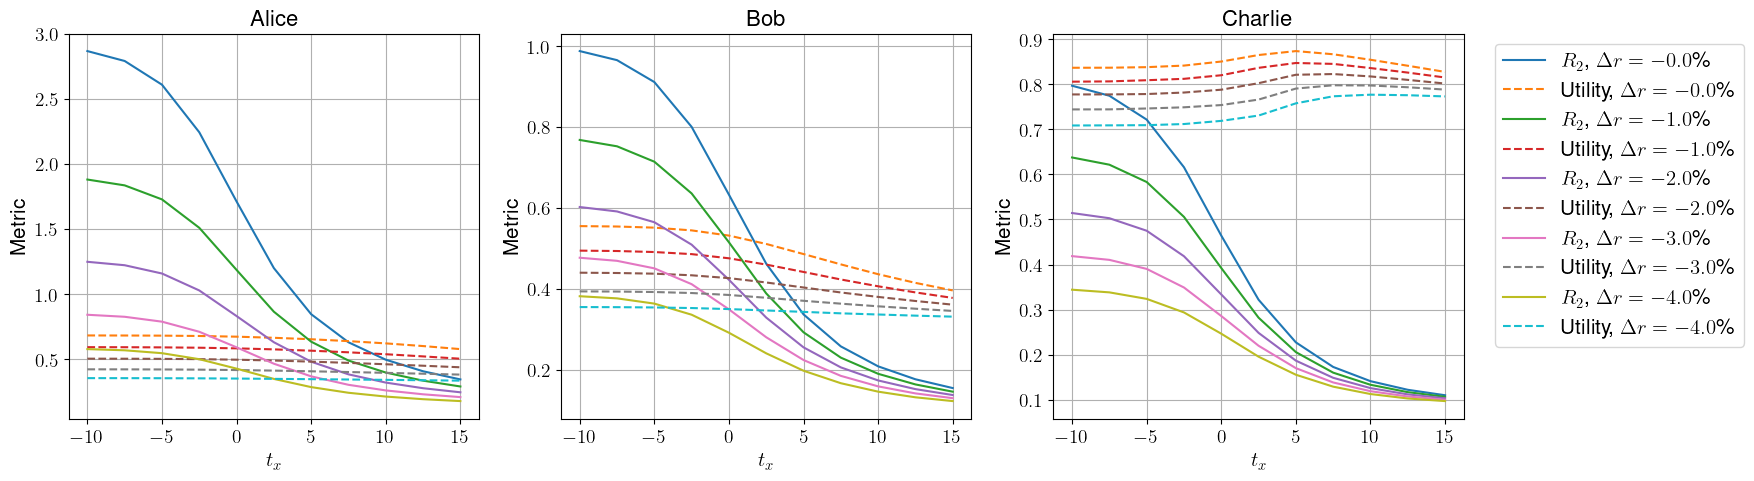

In [34]:
_,axs=plt.subplots(1,3,figsize=(18,5))
for ax,pn in zip(axs,['Alice','Bob','Charlie']):
    ax.set_xlabel('$t_x$',fontsize=15)
    ax.set_ylabel('Metric',fontsize=15)
    ax.set_title(pn,fontsize=16)
    ax.grid()
    ax.tick_params(labelsize=14)

p_data_pr = {'Alice':[],'Bob':[],'Charlie':[]}
for p_data_tx,delta_r in zip(p_data_stocks,stocks_less):
    for pn,pr,ax in zip(p_data_tx.keys(),[alice,bob,charlie],axs):
        w0_dep=pd.DataFrame(np.vstack(p_data_tx[pn]),
                     index=tx_set,
                     columns=['W_0 req','Prob Pct','Utility','Risk','R_{max}','Run Out 10pct','Avg Time Run Out','Utility conditional','Avg Stocks Weight']).assign(Prob=lambda x: x['Prob Pct']/100.)
        p_data_pr[pn].append(w0_dep)
        
for ax,pn in zip(axs,['Alice','Bob','Charlie']):
    for delta_r,w0_dep in zip(stocks_less,p_data_pr[pn]):
        ax.plot(w0_dep.index,w0_dep['Risk'],label='$R_2$, $\Delta r=-{:.1f}$\%'.format(delta_r*100))
        ax.plot(w0_dep.index,w0_dep['Utility'],label='Utility, $\Delta r=-{:.1f}$\%'.format(delta_r*100),linestyle='--')
    if pn=='Charlie':
        ax.legend(fontsize=15,bbox_to_anchor=(1.05,1))

plt.show()

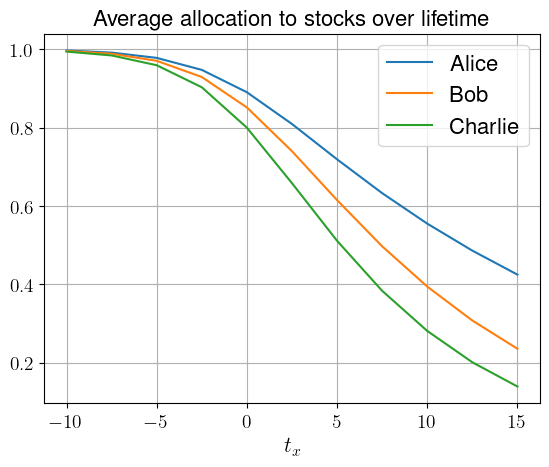

In [37]:
pd.concat([pd.DataFrame(np.vstack(p_data_tx[pn]),
                 index=tx_set,
                 columns=['W_0 req','Prob Pct','Utility','Risk','R_{max}','Run Out 10pct','Run Out 50pct','Utility conditional','Avg Stocks Weight'])[['Avg Stocks Weight']].rename(columns=lambda x: pn) 
           for pn in ['Alice','Bob','Charlie']],axis=1).plot(grid=True)
plt.title('Average allocation to stocks over lifetime',fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel('$t_x$',fontsize=16)
plt.show()


In [38]:
n_levs=[50,80,90,95,100]
w_mins={n:np.zeros(alice.T+1) for n in n_levs}
for n in n_levs:
    print('Calculating w_min for Utility target={}\%'.format(n))
    for t in range(T_run):
        pr = copy.copy(alice)
        pr.inflows=pr.inflows[t:]
        pr.goals=pr.goals[t:]
        pr.T = T_run-t
        gp = build_policy_for_goals(x_implied,pr.goals)
        w_mins[n][t+1]=min_wealth_for_policy_(ann_paths,pr,gp,n/100.)    

Calculating w_min for Utility target=50\%
Calculating w_min for Utility target=80\%
Calculating w_min for Utility target=90\%
Calculating w_min for Utility target=95\%
Calculating w_min for Utility target=100\%


Text(0.5, 1.0, 'Required wealth for achieving desired level of remaining Utility')

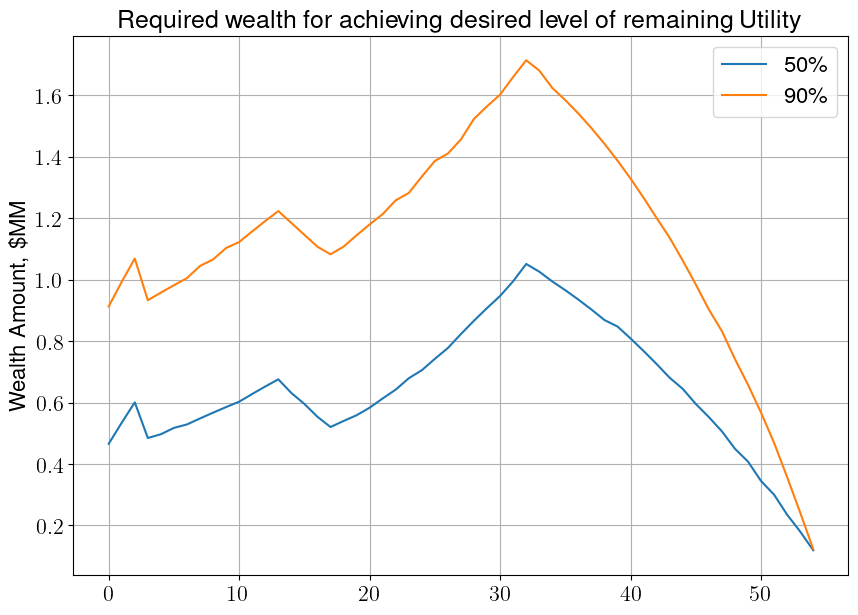

In [39]:
pd.DataFrame(np.column_stack((0.1*w_mins[50][1:],0.1*w_mins[90][1:])),columns=['50\%','90\%']).plot(grid=True,fontsize=16,figsize=(10,7))
plt.legend(fontsize=16)
plt.ylabel('Wealth Amount, \$MM',fontsize=16)
plt.title('Required wealth for achieving desired level of remaining Utility',fontsize=18)

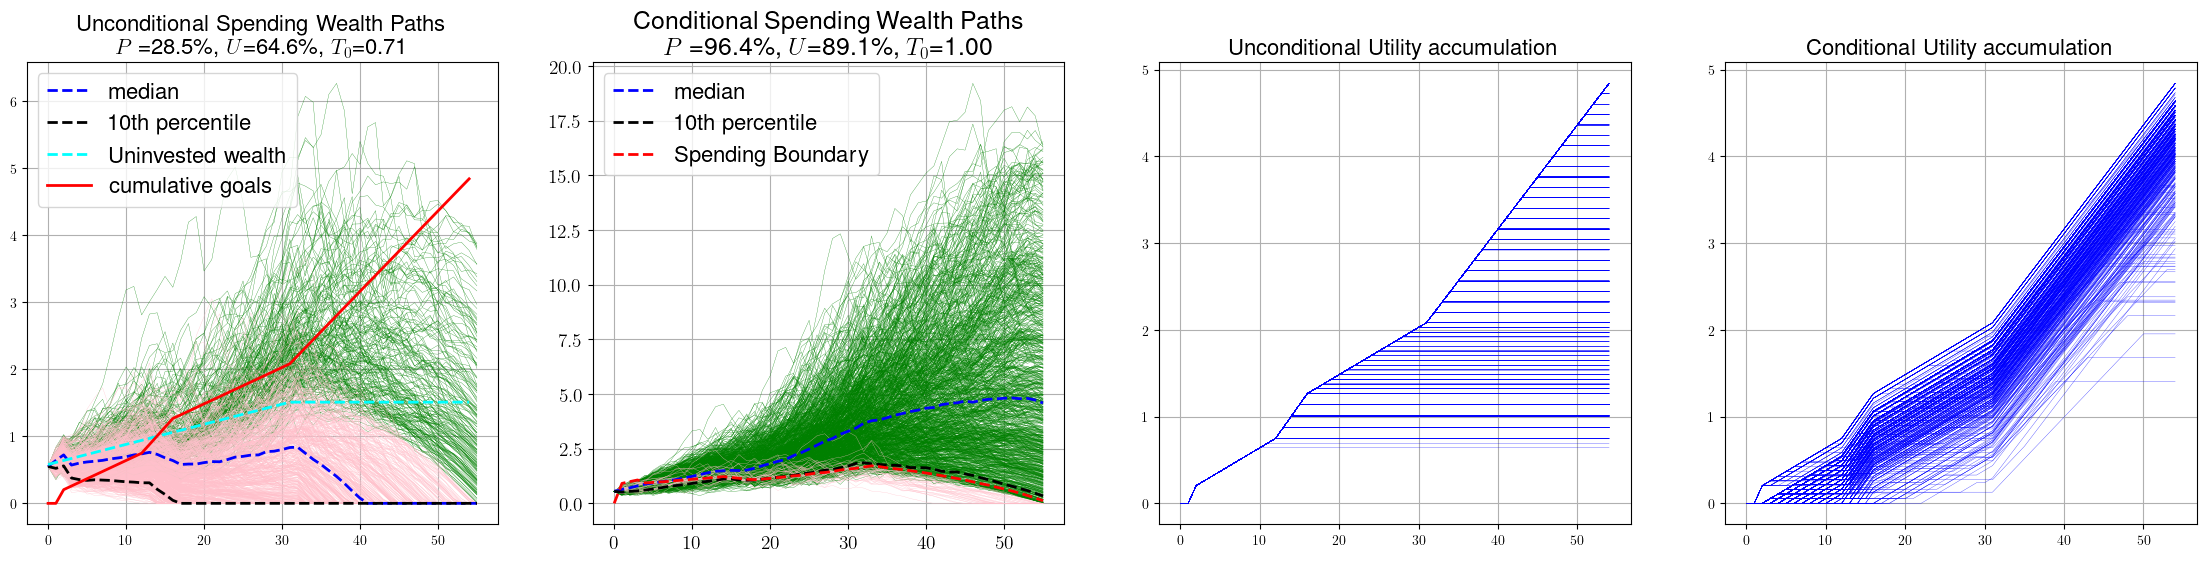

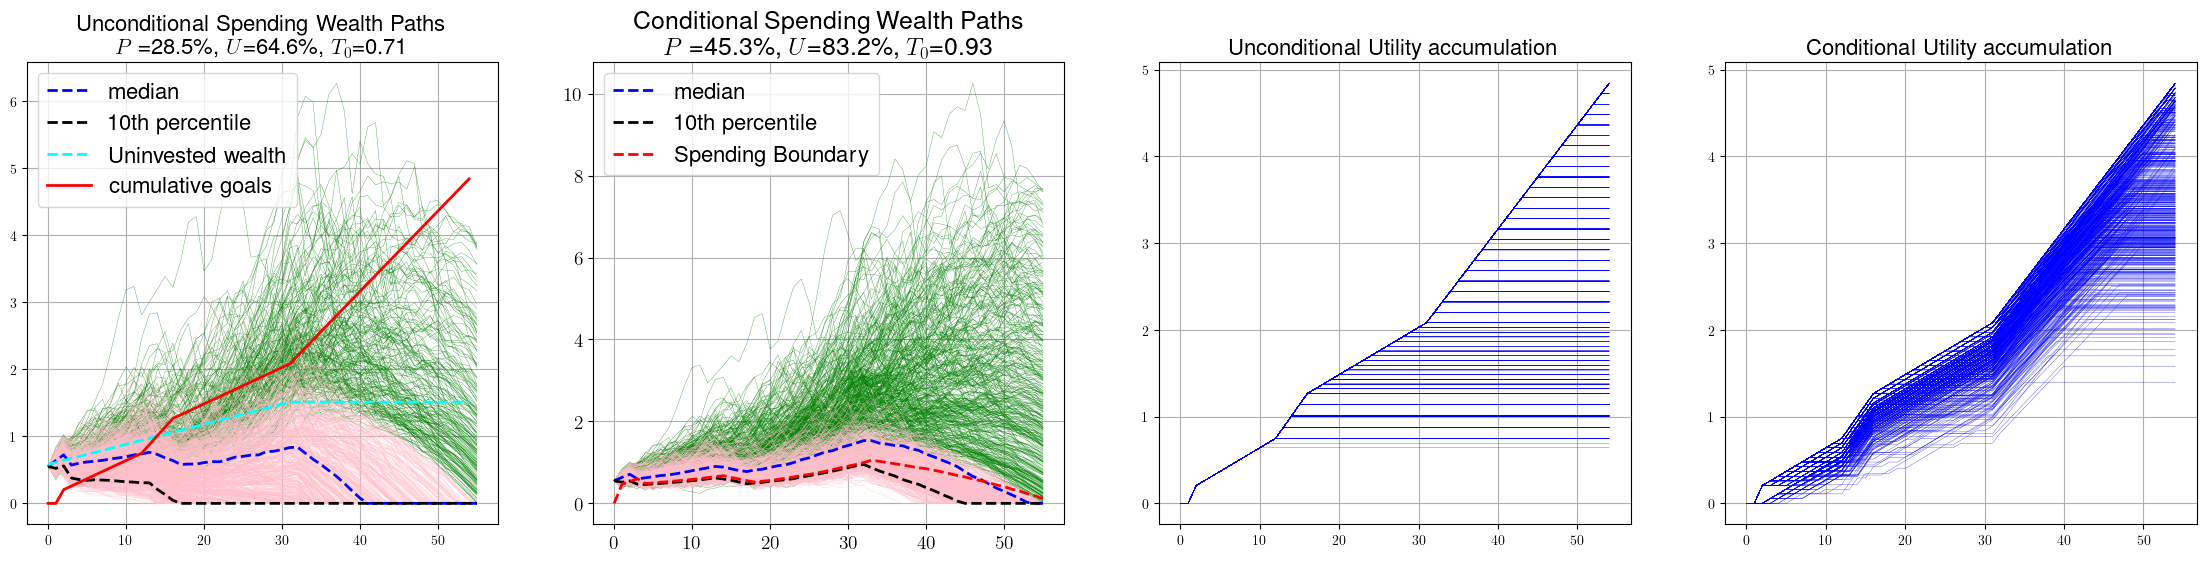

In [40]:

result=simulate_wealth_with_threshold_(ann_paths[:,:,random1000],alice,gp_implied,w_mins[90],vis=True,show_paths=True,scale=0.1)
result=simulate_wealth_with_threshold_(ann_paths[:,:,random1000],alice,gp_implied,w_mins[50],vis=True,show_paths=True,scale=0.1)


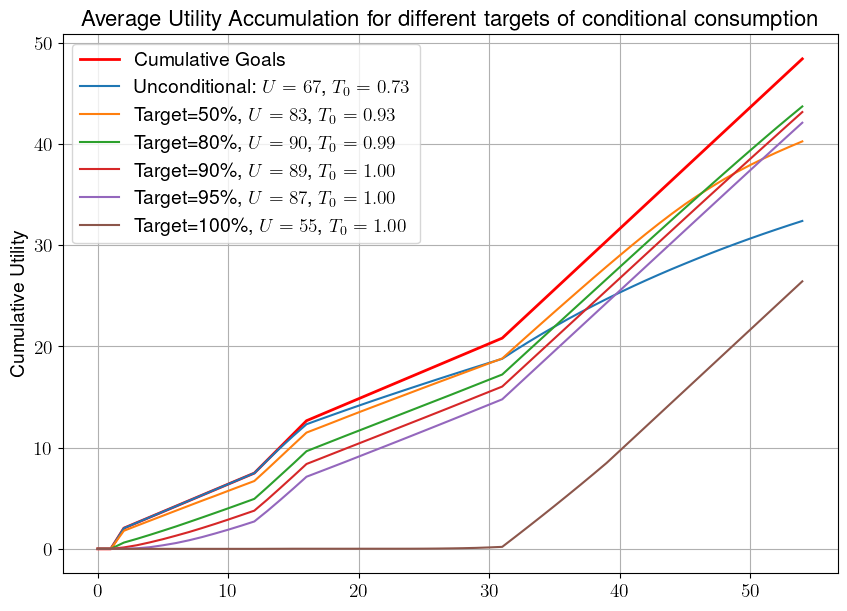

In [41]:
result0=simulate_wealth_with_threshold_(ann_paths[:,:,random1000],alice,gp_implied,np.zeros(alice.T+1),vis=False,show_paths=False,scale=0.1)
u_paths0=result0[-1].cumsum(axis=0).mean(axis=1)
u0=result0[6]
run_out0=result0[-2]

_,ax=plt.subplots(figsize=(10,7))
ax.plot(alice.goals.cumsum(),label='Cumulative Goals',color='r',linewidth=2)
ax.plot(u_paths0,label='Unconditional: $U={:.0f}$, $T_0={:.2f}$'.format(u0,run_out0))
for n in n_levs:
    result=simulate_wealth_with_threshold_(ann_paths[:,:,random1000],alice,gp_implied,w_mins[n],vis=False,show_paths=False,scale=0.1)
    u_paths = result[-1].cumsum(axis=0).mean(axis=1)
    run_out = result[-2]
    u = result[6]
    ax.plot(u_paths,label='Target={:.0f}\%, $U={:.0f}$, $T_0={:.2f}$'.format(n, u,run_out))
ax.grid()
ax.legend(fontsize=14,loc='upper left')
ax.tick_params(labelsize=14)
ax.set_ylabel('Cumulative Utility',fontsize=14)
ax.set_title('Average Utility Accumulation for different targets of conditional consumption',fontsize=16)
plt.show()

### Different priority and individual compositions

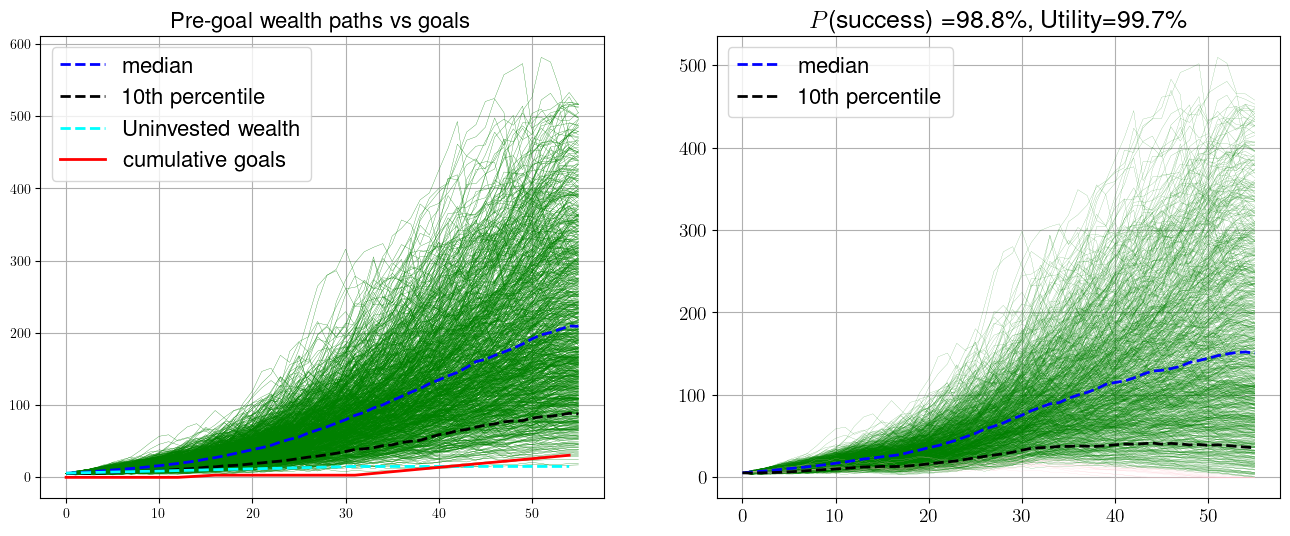

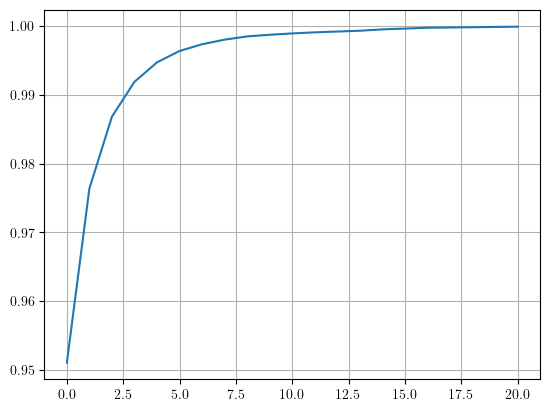

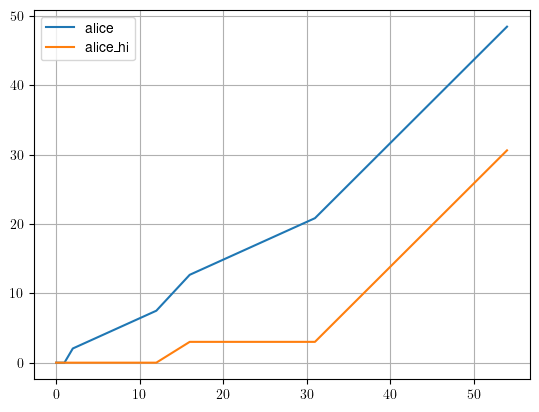

W min alice hi= 0.0
W min alice= 9.12703245044611
MDD= 1.0627351724041558
RD= 0.3039097835866643
$T_0$= 0.9985818181818181


In [42]:
gp_implied_alice_hi=build_policy_for_goals(x_implied,alice_hi.goals)
gp_implied_alice=build_policy_for_goals(x_implied,alice.goals)
result_alice_hi=simulate_wealth_(ann_paths[:,:,random1000],
                                 alice_hi,
                                 gp_implied_alice_hi,
                                 vis=True,
                                 show_paths=True,
                                 scale=1.)
wmin_alice_hi=min_wealth_for_policy_(ann_paths,alice_hi,gp_implied_alice_hi,0.90)
u_hi=[]
for w0 in np.linspace(0,20,21):
    pr=copy.copy(alice_hi)
    pr.starting_wealth=w0
    res=simulate_wealth_(ann_paths[:,:,random1000],
                         pr,
                         gp_implied_alice_hi)
    u_hi.append(res[3])
pd.Series(u_hi).plot(grid=True)
    
wmin_alice=min_wealth_for_policy_(ann_paths,alice,gp_implied_alice,0.90)
pd.DataFrame({'alice':alice.goals.cumsum(),'alice_hi':alice_hi.goals.cumsum()}).plot(grid=True)
plt.show()

print('W min alice hi=',wmin_alice_hi)
print('W min alice=',wmin_alice)
print('MDD=', result_alice_hi[4]/alice_hi.goals.sum())
print('RD=', np.diff(result_alice_hi[2],axis=0).std(axis=0).mean()/alice_hi.goals.sum())
print(r'$T_0$=',avg_exit_time(result_alice_hi[0]))

In [43]:
wmins_hi=np.zeros(T_run)
for t in range(T_run):
    pr = copy.copy(alice_hi)
    pr.inflows=pr.inflows[t:]
    pr.goals=pr.goals[t:]
    pr.T = T_run-t
    gp = build_policy_for_goals(x_implied,pr.goals)
    wmins_hi[t]=min_wealth_for_policy_(ann_paths,pr,gp,0.9)   

In [44]:
wmins_lo=np.zeros(T_run)
for t in range(T_run):
    pr = copy.copy(alice)
    pr.inflows=pr.inflows[t:]
    pr.goals=pr.goals[t:]
    pr.T = T_run-t
    gp = build_policy_for_goals(x_implied,pr.goals)
    wmins_lo[t]=min_wealth_for_policy_(ann_paths,pr,gp,0.75)  

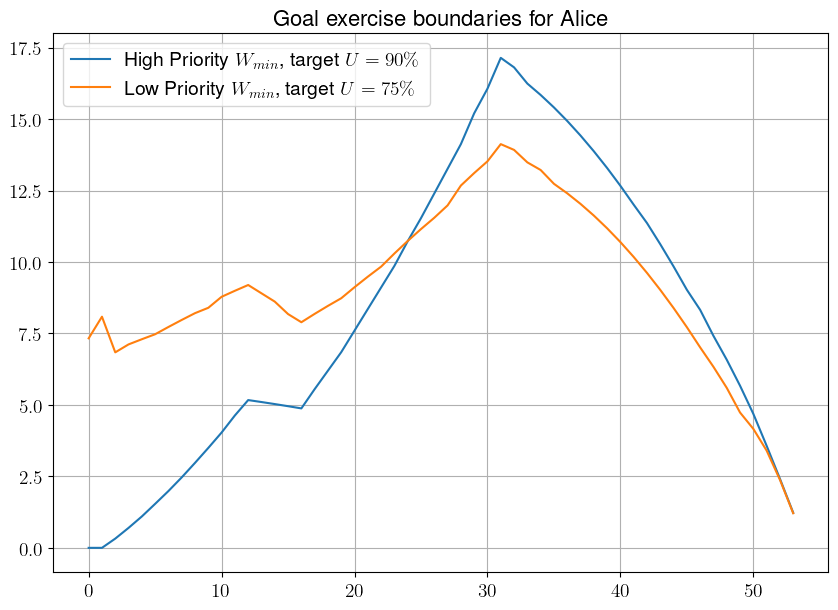

In [45]:
pd.DataFrame({'High Priority $W_{min}$, target $U = 90\%$':wmins_hi[1:],
              'Low Priority $W_{min}$, target $U = 75\%$':wmins_lo[1:]}).plot(grid=True,fontsize=14,figsize=(10,7))
plt.title('Goal exercise boundaries for Alice',fontsize=16)
plt.legend(fontsize=14)
plt.show()

### Multiple priorities handling

Suppose goals 1,2 and 3 are high priority, and the rest of the goals are low priority. We can introduce two decision boundaries at different target levels (which potentially could be adjusted to maximize the overall utilities). If at decision time $W_t > W_t^{min, HI}$ then we can fund the high priority goal at that moment.

\begin{equation*}
W^{min}_t = F\left([...],[g_1,g_2,\ldots,g_n],U_{target}\right)
\end{equation*}

\begin{equation*}
W^{min, HI}_t=F\left([...],[g_1,g_2,g_3],U_{target}=90\%\right)\\
W^{min, LO}_t=F\left([...],[g_1,g_2,\ldots,g_n],U_{target}=75\%\right)
\end{equation*}

### Refinement of the goal execution strategy ###

Previously we considered spending money on goals only if the running wealth $W_t$ exceeded the pre-calculated threshold $W_t^{min}$. The threshold was based on the estimated equivalent of present value of _all_ remaining goals. However, a more nuanced strategy is possible: what if not all but some of the future goals can be funded along with the current one? In that case it is a matter of preference (spending money today means some of the future goals are very unlikely to get funded). If utility is the only criterion then the decision boils down to finding the combination of goals with the largest value less than $W_t$ where the value for any subset of goals is defined by recalculating $W^{min}$ with those goals removed and subtracting the value of $W^{min}$ for all the goals:
\begin{equation*}
V[g_k,U_{target}]_t=F\left([g_1,\ldots,0_k,\ldots,g_n]\right)-W^{min}
\end{equation*}

\begin{equation*}
V[g_{k_1},\ldots,g_{k_P}]=F\left([\ldots,0_{k_1},\ldots,0_{k_P},\ldots]\right)-W^{min}
\end{equation*}
If such optimal combination of goals includes the one on which we have to make the decision we can commit, otherwise we punt knowing that with high probability a certain combination of remaining future goals will be funded.

### Combining multiple users 

Does it help? Not with the case of 2 of them. Perhaps you need many. Or perhaps this is the reason Eurozone does not work. Combing Germany with Greece helps Greece a little bit but certainly does not help Germany.


In [46]:
alice_and_bob_min_spending_obj=min_spending_obj.add(bob_min_spending_obj)
alice_and_bob=Profile(alice.profile_obj_list+bob.profile_obj_list,
                      alice.goals_list+bob.goals_list,
                      max(alice.T,bob.T),
                      alice.starting_wealth+bob.starting_wealth,
                     min_spending_obj=alice_and_bob_min_spending_obj)

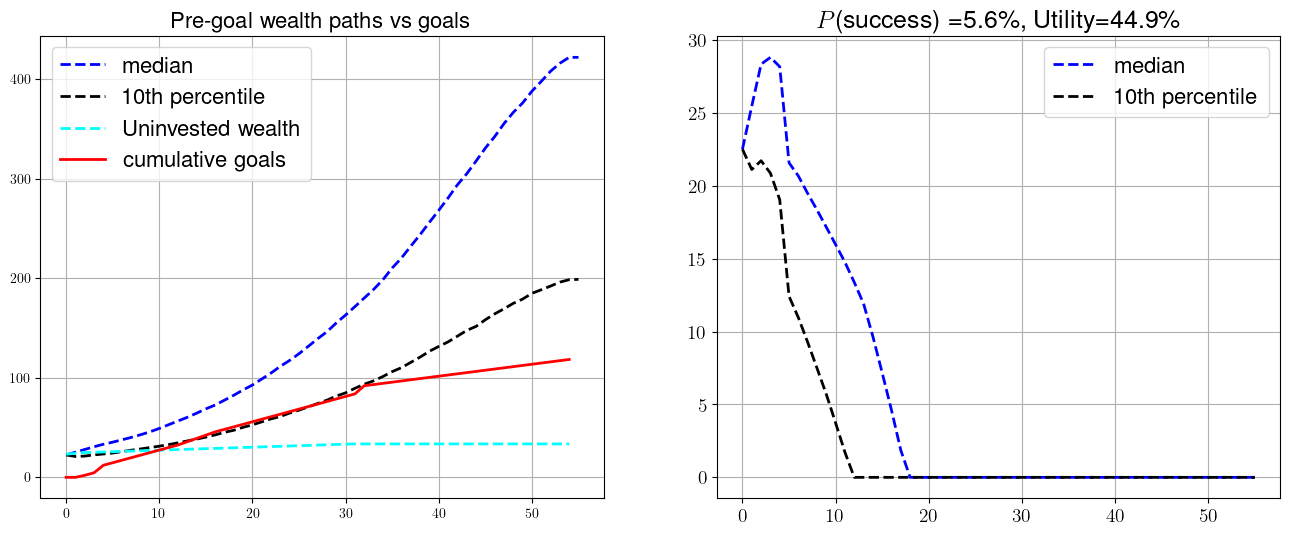

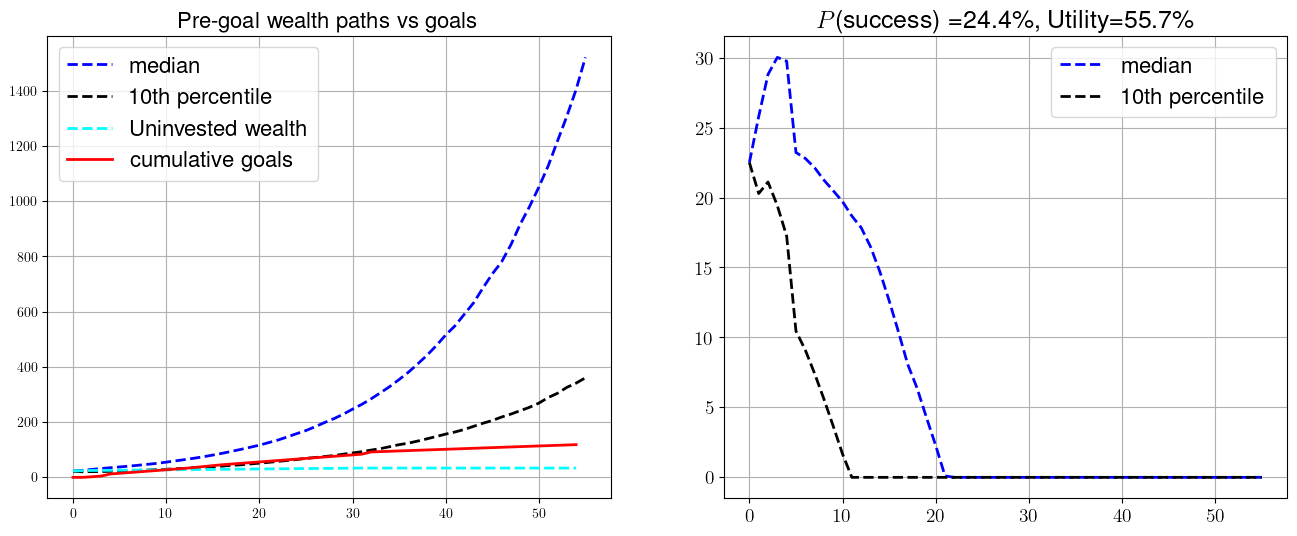

Alice


w0_req   prob      util      risk        mdd  run_out10  \
implied      9.127032  26.08  0.622141  0.496744   1.722846       16.0   
stocks only  8.843291  43.94  0.683254  2.912136  10.660329       15.0   

             avg_run_out  util cond  avg stocks weight  
implied         0.687507   0.675751           0.554727  
stocks only     0.733316   0.733670           0.999940

Bob


w0_req   prob      util      risk       mdd  run_out10  \
implied      32.539062   1.12  0.436499  0.208868  0.580878       10.0   
stocks only  31.445312  18.25  0.555967  1.001203  2.956633        9.0   

             avg_run_out  util_cond  avg stocks weight  
implied         0.477264   0.488854           0.393946  
stocks only     0.591109   0.615983           0.999920

Alice and Bob


w0_req   prob      util      risk        mdd  run_out10  \
implied      41.865191   5.60  0.449221  0.491639   1.678254       11.0   
stocks only  41.402592  24.36  0.556960  3.975863  14.545066       10.0   

             avg_run_out  util cond  avg stocks weight  
implied         0.381675   0.542606           0.455683  
stocks only     0.504349   0.642454           0.996061

In [47]:
gp_alice_and_bob=build_policy_for_goals(x_implied,alice_and_bob.goals)
gp_alice_and_bob_stocks_only=build_policy_for_goals(x_implied*np.array([1,-1,1]),alice_and_bob.goals)
out_comp_alice_and_bob=pd.DataFrame(np.vstack([evaluate(alice_and_bob,policy,ann_paths,vis=True) for policy in [gp_alice_and_bob,gp_alice_and_bob_stocks_only]]),
                              columns=['w0_req','prob','util','risk','mdd','run_out10','avg_run_out','util cond','avg stocks weight'],
                              index=['implied','stocks only'])
print('Alice')
display(out_comp)
print('Bob')
display(out_comp_bob)
print('Alice and Bob')
display(out_comp_alice_and_bob)